<a id='toc'></a>
# Тестирование входных данных

1. [Тесты нормативно-справочной информации](#21)
  1. [Количество станций](#211)
  2. [Станции смены бригад](#212)
  3. [Станции смены локомотивов](#213)
  4. [Покрытие тяговыми плечами](#214)
  5. [Покрытие участками обкатки бригад](#215)
2. [Тесты по поездам](#22)
  1. [Простые тесты (поезда переданы в планировщик без дублирования, со всеми атрибутами и местоположением](#221)  
  2. [Корректность фактов о местоположении](#222)
    1. [Присутствие станции или участка в соответствующем справочнике](#2221)
    2. [Присутствие станции или участка в маршруте поезда](#2222)
  3. [Корректное время отправления поезда](#223)
  4. [Связь поезда с локомотивом](#224)
  5. [Соединенные поезда](#225)
3. [Тесты по локомотивам](#23)
  1. [Простые тесты (локомотивы переданы в планировщик без дублирования, со всеми атрибутами и местоположением](#231)
  2. [Корректность местоположения локомотивов](#232)
  3. [Время и пробег до ТО-2](#233)  
  4. [Связь локомотива с поездом](#234)
  5. [Связь локомотива с бригадой](#235)  
  6. [Наличие локомотивов на всех тяговых плечах](#236)
  7. [Покрытие локомотивами всех участков планирования](#237)
  8. [Проверка корректности типа локомотивов](#238)
4. [Тесты по бригадам](#24)
  1. [Простые тесты (бригады переданы без дублирования со всеми атрибутами и местоположением)](#241)
  2. [Корректность местоположения и станций явок бригад](#242)
  3. [Корректность данных по временам явок в зависимости от состояния бригад](#243)
    1. [Бригады пассажирами (состояние 0)](#2431)
    2. [Бригады с локомотивами на перегонах (состояние 1)](#2432)
    3. [Бригады на явке в депо приписки или на домашнем отдыхе (состояние 2 или 3)](#2433)
    4. [Бригады на отдыхе в пункте оборота (состояние 4)](#2434)
    5. [Бригады с локомотивами на станции (состояние 5, 6 или 9)](#2435)
    6. [Бригады, прибывшие пассажиром (состояние 7)](#2436)
    7. [Бригады на явке в пункте оборота (состояние 8)](#2437)
  4. [Связь бригады с локомотивом](#244)
  5. [Наличие бригад на всех участках обкатки](#245)
  6. [Покрытие бригадами всех участков планирования](#246)
  7. [Проверка корректности типа бригады](#247)
3. [Результаты тестов](#res)
4. [Цифры по связанности для выгрузки в Excel](#excel)
5. [Запаздывание операций](#lag)

In [1]:
report = ''
FOLDER = 'resources/'
REPORT_FOLDER = 'report/'
PRINT = True

In [2]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:        
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="40%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()    
    print('Отчет сформирован и сохранен в файл %s' % filename)    
    print('Время выполнения: %.2f сек.' % (time.time() - start_time))

In [3]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)

time_format = '%b %d, %H:%M'

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv', converters={'st_from':str, 'st_to':str})
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str, 'joint':str,
                                                                 'oper_location':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str,
                                                                      'oper_location':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str,
                                                                       'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str,
                                                                       'return_st':str, 'oper_location':str})
team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')

team_info.regions = team_info.regions.apply(literal_eval)
st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
print('Log time: %d, %s' % (current_time, time.ctime(current_time)))
print('Read csvs:', np.round(time.time() - start_time, 2), 'sec')

Log time: 1465803212, Mon Jun 13 10:33:32 2016
Read csvs: 0.48 sec


In [4]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def colcount(df, col):
    return df[col].drop_duplicates().count() if col in df.columns else np.nan

def nice_time(t):
    try:
        return time.strftime(time_format, time.localtime(t))
    except:
        return ''

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_norm'] = df.time_start.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'time_end' in df.columns:
        df['time_end_norm'] = df.time_end.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    if 'oper_time' in df.columns:
        df['oper_time_f'] = df.oper_time.apply(lambda x: time.strftime(time_format, time.localtime(x)))       

    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
add_info(train_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] == '2' else 'Фейковая')

In [5]:
add_line('Время запуска планировщика: %s' % nice_time(current_time))
add_header('Тестирование входных данных в планировщике', h=1, p=False)

Время запуска планировщика: Jun 13, 10:33


<a id='21'></a>
## Тесты нормативно-справочной информации [ToC](#toc)

In [6]:
add_header('2.1. Тесты нормативно справочной информации', h=2, p=False)

In [7]:
result = {}

<a id='211'></a>
### Количество станций [ToC](#toc)

In [8]:
add_header('2.1.1. Количество станций', h=3, p=False)

In [9]:
st_num = stations.station.drop_duplicates().count()
if st_num > 0:
    add_line('Всего передано станций: %d' % st_num)
    result['2.1.1'] = True
else:
    add_line('FAIL: во входных данных отсутствуют станции')
    result['2.1.1'] = False

Всего передано станций: 351


<a id='212'></a>
### Станции смены бригад [ToC](#toc)

In [10]:
add_header('2.1.2. Станции смены бригад', h=3, p=False)

In [11]:
st_norm_time = stations[stations.norm_time != 0]
st_norm_time_n = st_norm_time.station.drop_duplicates().count()
if st_norm_time_n / st_num >= 0.1:
    add_line('Всего передано станций смены бригад: %d' % st_norm_time_n)
    result['2.1.2'] = True
else:
    add_line('FAIL: количество станций смены бригад (%d) меньше ожидаемого (%d)' % ())
    result['2.1.2'] = False

Всего передано станций смены бригад: 69


<a id='213'></a>
### Станции смены локомотивов [ToC](#toc)

In [12]:
add_header('2.1.3. Станции смены локомотивов', h=3, p=False)

<a id='214'></a>
### Покрытие тяговыми плечами [ToC](#toc)

In [13]:
add_header('2.1.4. Покрытие тяговыми плечами', h=3, p=False)

In [14]:
links['link'] = list(zip(links.st_from, links.st_to))
add_info(links)
st_reg = stations.groupby('station').loco_region.unique()
links['st_from_regs'] = links.st_from.map(st_reg)
links['st_to_regs'] = links.st_to.map(st_reg)
links['link_regs'] = links.st_from_regs.combine(links.st_to_regs, np.intersect1d)
links_no_reg = links[links.link_regs.apply(len) == 0]
if links_no_reg.empty:
    add_line('Все участки планирования покрыты тяговыми плечами')
    result['2.1.4'] = True
else:
    add_header('FAIL: Всего %d участков планирования без тяговых плеч:' % links_no_reg.link.count())
    add_line(links_no_reg)
    result['2.1.4'] = False

FAIL: Всего 10 участков планирования без тяговых плеч:
                     link     st_from       st_to  time  dist  dir  lines  road  st_from_name    st_to_name  st_from_regs    st_to_regs link_regs
 (2000038434, 2000038426)  2000038434  2000038426  2940    43    1      2    96           NaN          БИРА           NaN  [2002119294]        []
 (2000038440, 2000038442)  2000038440  2000038442  2520    39    1      1    96     БИРОФЕЛЬД           NaN  [2002119294]           NaN        []
 (2000038434, 2000038442)  2000038434  2000038442   600     9    0      1    96           NaN           NaN           NaN           NaN        []
 (2000039072, 2002026607)  2000039072  2002026607   600    13    0      1    96      МАХАЛИНО           NaN  [2002119292]           NaN        []
 (2000038442, 2000038434)  2000038442  2000038434   540     9    1      1    96           NaN           NaN           NaN           NaN        []
 (2000038442, 2000038440)  2000038442  2000038440  2520    39    0   

<a id='215'></a>
### Покрытие участками обкатки бригад [ToC](#toc)

In [15]:
add_header('2.1.5. Покрытие участками обкатки бригад', h=3, p=False)

In [16]:
if 'link_eval' not in twr.columns:
    twr['link_eval'] = twr.link.apply(literal_eval)
    twr['st_from'] = twr.link_eval.apply(lambda x: str(x[0]))
    twr['st_to'] = twr.link_eval.apply(lambda x: str(x[1]))

twr['link'] = list(zip(twr.st_from, twr.st_to))
links['link_twr'] = links.link.map(twr.groupby('link').twr.unique())
links_nan = links[links.link_twr.isnull()]
links_not_nan = links.dropna(subset=['link_twr'])
links_no_twr = links_not_nan[links_not_nan.link_twr.apply(len) == 0]
if (links_nan.empty) | (links_no_twr.empty):
    add_header('FAIL: Всего %d участков планирования без покрытия участками обкатки бригад. Примеры:' 
          % (links_nan.link.count() + links_no_twr.link.count()))
    if not links_nan.empty:
        add_line(links_nan[['link', 'st_from_name', 'st_to_name', 'link_twr']].head(30))
    if not links_no_twr.empty:
        add_line(links_no_twr[['link', 'st_from_name', 'st_to_name', 'link_twr']].head(30))
    result['2.1.5'] = False
else:
    add_line('Все участки планирования покрыты участками обкатки бригад')
    result['2.1.5'] = True

FAIL: Всего 26 участков планирования без покрытия участками обкатки бригад. Примеры:
                     link          st_from_name            st_to_name link_twr
 (2000038440, 2000038142)             БИРОФЕЛЬД               ЛЕНИНСК      NaN
 (2000035496, 2000035528)                 АСКИЗ                 АБАЗА      NaN
 (2000038440, 2000038442)             БИРОФЕЛЬД                   NaN      NaN
 (2000035954, 2000035896)                   УЯР                ЗЫКОВО      NaN
 (2000038630, 2000038644)       ПОСТ-ПОКРОВСКИЙ     ПОКРОВКА-ПРИСТАНЬ      NaN
 (2000038138, 2000038162)           СКОВОРОДИНО               РЕЙНОВО      NaN
 (2000038434, 2000038442)                   NaN                   NaN      NaN
 (2000038442, 2000038434)                   NaN                   NaN      NaN
 (2000038442, 2000038440)                   NaN             БИРОФЕЛЬД      NaN
 (2000037222, 2000037200)                БАЙКАЛ                КУЛТУК      NaN
 (2000035896, 2000035954)                ЗЫКОВ

<a id='22'></a>
## Тесты по поездам [ToC](#toc)

In [17]:
add_header('2.2. Тесты по поездам', h=2, p=False)

<a id='221'></a>
### Простые тесты (поезда переданы без дублирования, с заполненными атрибутами и местоположением) [ToC](#toc)

In [18]:
add_header('2.2.1. Поезда переданы в планировщик', h=3, p=False)
result['2.2.1'] = True

In [19]:
train_n = train_info.train.drop_duplicates().count()
if train_n > 0:
    add_line('Всего %d поездов передано в планировщик' % train_n)
    result['2.2.1'] = result['2.2.1'] & True    
else:
    add_line('FAIL: поезда не переданы в планировщик')
    result['2.2.1'] = result['2.2.1'] & False

Всего 509 поездов передано в планировщик


In [20]:
tr = train_info.train.value_counts()
non_unique_trains = tr.loc[tr > 1]
if len(non_unique_trains.index) == 0:
    add_line('Неуникальных поездов не найдено')
    result['2.2.1'] = result['2.2.1'] & True
else:
    add_header('Всего неуникальных поездов: %d' % len(non_unique_trains.index))
    add_line(train_info.loc[train_info.train.isin(non_unique_trains.index)].head(10))
    result['2.2.1'] = result['2.2.1'] & False

Неуникальных поездов не найдено


In [21]:
tr_bad_attr = train_info[(train_info.number.apply(lambda x: type(x) != np.int64))
                      | (train_info.weight.apply(lambda x: type(x) != np.int64))
                      | (train_info.length.apply(lambda x: type(x) != np.int64))]
tr_bad_attr_n = tr_bad_attr.train.drop_duplicates().count()
if tr_bad_attr_n == 0:
    add_line('Все атрибуты для поездов заполнены')
    result['2.2.1'] = result['2.2.1'] & True
else:
    add_header('FAIL: для %d поездов не переданы номер, вес или длина' % tr_bad_attr_n)
    cols = ['train', 'number', 'weight', 'length', 'ind434', 'oper_time', 'oper_location']
    add_line(tr_bad_attr[cols].head(10))
    result['2.2.1'] = result['2.2.1'] & False

Все атрибуты для поездов заполнены


In [22]:
routes = pd.read_csv(FOLDER + 'routes.csv', converters={'train':str, 'st_from':str, 'st_to':str})
add_info(routes)
tr_no_routes = train_info[train_info.train.isin(routes.train) == False]
if tr_no_routes.empty:
    add_line('Для всех поездов переданы маршруты')
    result['2.2.1'] = result['2.2.1'] & True
else:
    tr_no_routes_n = tr_no_routes.train.drop_duplicates().count()
    add_header('FAIL: всего %d поездов без маршрута:' % tr_no_routes_n)
    cols = ['train', 'number', 'weight', 'length', 'ind434', 'oper_time', 'oper_location']
    add_line(tr_no_routes.head(10)[cols])
    result['2.2.1'] = result['2.2.1'] & False    

Для всех поездов переданы маршруты


In [23]:
tr_bad_loc = train_info[(train_info.oper_location.isnull()) | (train_info.oper_location == '-1')]
tr_bad_loc_n = tr_bad_loc.train.drop_duplicates().count()
if tr_bad_loc_n == 0:
    add_line('Все местоположения для поездов заполнены')
    result['2.2.1'] = result['2.2.1'] & True
else:
    add_header('FAIL: для %d поездов не передано местоположение' % tr_bad_loc_n)
    cols = ['train', 'number', 'weight', 'length', 'ind434', 'oper_time', 'oper_location']
    add_line(tr_bad_loc[cols].head(10))
    result['2.2.1'] = result['2.2.1'] & False

Все местоположения для поездов заполнены


<a id='222'></a>
### Корректность фактов о местоположении [ToC](#toc)

In [24]:
add_header('2.2.2. Корректность фактов о местоположении поездов', h=3, p=False)
result['2.2.2'] = True

<a id='2221'></a>
#### Присутствие станции или участка в соответствующем справочнике [ToC](#toc)

In [25]:
pd.set_option('display.max_colwidth', 50)
bad_loc_st = train_info[(train_info.st_from == '-1') & (train_info.oper_location.isin(stations.station) == False)]
bad_loc_st_n = colcount(bad_loc_st, 'train')
if bad_loc_st_n == 0:
    add_header('Для всех поездов, находящихся на станциях, заданы корректные станции')
    result['2.2.2'] = result['2.2.2'] & True
else:
    add_header('Всего %d поездов, находящихся на станциях (%.2f%%), для которых заданы некорректные станции. Примеры:' 
          % (bad_loc_st_n, 100 * bad_loc_st_n / colcount(train_info[train_info.st_from == '-1'], 'train')))
    add_line(bad_loc_st[['train', 'oper_time', 'oper_location', 'loc_name']])
    result['2.2.2'] = result['2.2.2'] & False

train_info['link'] = list(zip(train_info.st_from, train_info.st_to))
bad_loc_link = train_info[((train_info.st_from != '-1') | (train_info.st_to != '-1')) 
                          & (train_info.link.isin(links.link) == False)]
bad_loc_link_n = colcount(bad_loc_link, 'train')
if bad_loc_link_n == 0:
    add_header('Для всех поездов, находящихся на участках, заданы корректные участки планирования')
    result['2.2.2'] = result['2.2.2'] & True
else:
    add_header('Всего %d поездов, находящихся на участках (%.2f%%), для которых заданы некорректные участки. Примеры:' 
          % (bad_loc_link_n, 
             100 * bad_loc_link_n / colcount(train_info[((train_info.st_from != '-1') | (train_info.st_to != '-1'))], 'train')))
    add_line(bad_loc_link[['train', 'oper_time', 'st_from', 'st_to', 'loc_name']])
    result['2.2.2'] = result['2.2.2'] & False
pd.set_option('display.max_colwidth', 30)

Для всех поездов, находящихся на станциях, заданы корректные станции
Всего 7 поездов, находящихся на участках (2.61%), для которых заданы некорректные участки. Примеры:
        train   oper_time     st_from       st_to                         loc_name
 210207703415  1465789740  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 200251508160  1465803300  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 220200780731  1465789560  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 200251701951  1465800720  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 200251721145  1465802100  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 220200691566  1465802820  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 210209351814  1465802400  2002026607  2002026607                              NaN


<a id='2222'></a>
#### Присутствие станции или участка в маршруте поезда [ToC](#toc)

In [26]:
def check_route(oper, df):
    a = train_info[(train_info.oper == oper) & (train_info.train.isin(df.train) == False)]
    if a.empty:
        return True
    else:
        fail_n = a.train.drop_duplicates().count()
        add_header('FAIL: в маршруте поезда не указаны станция или участок из операции %s для %d поездов. Примеры:' 
              % (oper, fail_n))
        cols = ['train', 'oper', 'oper_location', 'oper_time', 'loc_name']
        add_line(a[cols].head(10 if fail_n > 20 else fail_n))
        add_line('')
        return False

routes['oper_st_from'] = routes.train.map(train_info.set_index('train').st_from)
routes['oper_st_to'] = routes.train.map(train_info.set_index('train').st_to)
routes['oper_st'] = routes.train.map(train_info.set_index('train').oper_location)
routes['oper_type'] = routes.train.map(train_info.set_index('train').oper)
routes['link'] = list(zip(routes.st_from, routes.st_to))
routes['info_link'] = list(zip(routes.oper_st_from, routes.oper_st_to))
routes['link_in_route'] = (routes.link == routes.info_link)
routes['st_in_route'] = (routes.st_from == routes.oper_st) | (routes.st_to == routes.oper_st)
cols = ['train', 'oper_type', 'link', 'info_link', 'oper_st', 'link_in_route', 'st_in_route']

check_dict = {'depart':'link_in_route', 'arrive':'st_in_route', 'ready':'st_in_route'}
for key in check_dict.keys():    
    df = routes[(routes.oper_type == key) & (routes[check_dict[key]] == True)]
    res = check_route(key, df)    
    result['2.2.2'] = result['2.2.2'] & res   
#routes[routes.train == '200230257428'][cols]

FAIL: в маршруте поезда не указаны станция или участок из операции depart для 19 поездов. Примеры:
        train    oper                 oper_location   oper_time                       loc_name
 200251704132  depart  ['2000037064', '2000037130']  1465782300            СУХОВСКАЯ - АНГАРСК
 200251425381  depart  ['2000037674', '2000037726']  1465739700                КАДАЛА - ЛЕСНАЯ
 200251383727  depart  ['2000038736', '2000038748']  1465791900              РУЖИНО - ШМАКОВКА
 200251231635  depart  ['2000035466', '2000039908']  1465801560        БИСКАМЖА - МЕЖДУРЕЧЕНСК
 210207703415  depart  ['2000037904', '2000037904']  1465789740  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВ...
 200251386269  depart  ['2000038736', '2000038748']  1465798680              РУЖИНО - ШМАКОВКА
 200251508160  depart  ['2000037904', '2000037904']  1465803300  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВ...
 200251482680  depart  ['2000038308', '2000038028']  1465803600         ЗАВИТАЯ - БЕЛОГОРСК II
 200251478585  depart  ['2000038402', '2000038

<a id='223'></a>
### Корректное время отправления поезда [ToC](#toc)

In [27]:
add_header('2.2.3. Корректное время отправления поездов', h=3, p=False)
result['2.2.3'] = True

In [28]:
current_time_f = time.strftime(time_format, time.localtime(current_time))
train_info['time_delta'] = current_time - train_info.oper_time
train_info['link'] = list(zip(train_info.st_from, train_info.st_to))
train_info['tt_link'] = train_info.link.map(links.set_index('link').time)
train_info['current_time_f'] = current_time_f
total_deps = train_info[train_info.oper == 'depart'].train.drop_duplicates().count()
cols = ['train', 'link', 'oper_time', 'oper_time_f', 'current_time_f', 'time_delta', 'tt_link']

#### Проверка поездов, отправленных до начала планирования

In [29]:
past_deps = train_info[(train_info.oper == 'depart') & (train_info.time_delta > 3 * train_info.tt_link)]
if not past_deps.empty:    
    add_header('FAIL: Всего %d поездов (%.2f%% от находящихся на перегоне) с временем отправления очень в прошлом' 
          % (past_deps.train.drop_duplicates().count(), 100 * past_deps.train.drop_duplicates().count() /  total_deps))
    add_line('Максимальное отставание времени отправления поезда по сравнению с временем начала планирования: %.2f ч.' 
          % ((past_deps.time_delta).max() / 3600))
    add_line(past_deps.sort_values('time_delta', ascending=False).head(10)[cols])    
    result['2.2.3'] = result['2.2.3'] & False
else:
    add_line('Нет случаев отправления поездов сильно в прошлом')
    result['2.2.3'] = result['2.2.3'] & True

FAIL: Всего 68 поездов (25.37% от находящихся на перегоне) с временем отправления очень в прошлом
Максимальное отставание времени отправления поезда по сравнению с временем начала планирования: 19.28 ч.
        train                      link   oper_time    oper_time_f current_time_f  time_delta  tt_link
 210209000251  (2000038048, 2000038060)  1465733820  Jun 12, 15:17  Jun 13, 10:33       69392     6120
 200251425381  (2000037674, 2000037726)  1465739700  Jun 12, 16:55  Jun 13, 10:33       63512     3120
 200251072696  (2000037746, 2000037548)  1465741500  Jun 12, 17:25  Jun 13, 10:33       61712     6540
 220200879497  (2000037632, 2000037642)  1465744620  Jun 12, 18:17  Jun 13, 10:33       58592     4140
 210207951792  (2000038410, 2000038426)  1465749180  Jun 12, 19:33  Jun 13, 10:33       54032     4620
 200251462454  (2000038016, 2000038010)  1465749300  Jun 12, 19:35  Jun 13, 10:33       53912     2880
 200251461689  (2000038072, 2000038088)  1465751700  Jun 12, 20:15  Jun 13, 

#### Проверка поездов, отправленных после начала планирования

In [30]:
# future
future_deps = train_info[(train_info.oper == 'depart') & (train_info.time_delta < 0)]
if not future_deps.empty:
    add_header('\nFAIL: Всего %d поездов (%.2f%% от находящихся на перегоне) с временем отправления в будущем' 
          % (future_deps.train.drop_duplicates().count(), 100 * future_deps.train.drop_duplicates().count() / total_deps))
    add_line('Максимальное превышение времени отправления поезда по сравнению с временем начала планировнаия: %.2f ч.' 
          % ((-future_deps.time_delta).max() / 3600))
    add_line(future_deps.sort_values('time_delta').head(10)[cols])
    result['2.2.3'] = result['2.2.3'] & False
else:
    add_line('Нет случаев отправления поездов в будущем')
    result['2.2.3'] = result['2.2.3'] & True


FAIL: Всего 42 поездов (15.67% от находящихся на перегоне) с временем отправления в будущем
Максимальное превышение времени отправления поезда по сравнению с временем начала планировнаия: 0.21 ч.
        train                      link   oper_time    oper_time_f current_time_f  time_delta  tt_link
 200251499729  (2000038634, 2000038624)  1465803960  Jun 13, 10:46  Jun 13, 10:33        -748     1020
 210211572486  (2000036208, 2000036246)  1465803960  Jun 13, 10:46  Jun 13, 10:33        -748     5280
 210211658103  (2000038088, 2000038102)  1465803900  Jun 13, 10:45  Jun 13, 10:33        -688     7740
 200251804027  (2000037746, 2000037548)  1465803900  Jun 13, 10:45  Jun 13, 10:33        -688     6540
 200251502446  (2000038904, 2000038902)  1465803840  Jun 13, 10:44  Jun 13, 10:33        -628      840
 200251471819  (2000036956, 2000037078)  1465803840  Jun 13, 10:44  Jun 13, 10:33        -628      720
 200251951020  (2000037542, 2000037540)  1465803840  Jun 13, 10:44  Jun 13, 10:33 

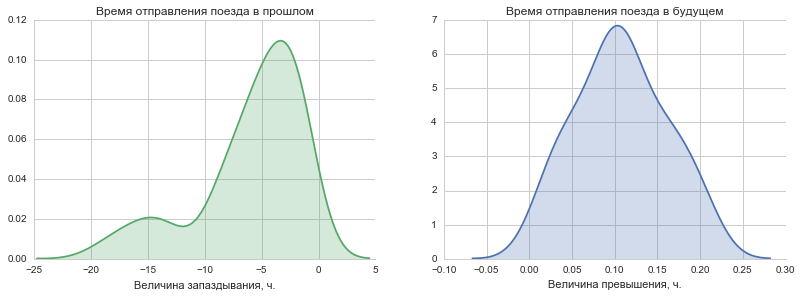

In [31]:
sns.set(context='notebook', style='whitegrid', color_codes='dark')
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
if past_deps.train.count() > 1:
    sns.distplot(-past_deps.time_delta/3600, hist=False, kde_kws={'shade':True}, color='g', ax=ax[0])
    ax[0].set(xlabel='Величина запаздывания, ч.', title='Время отправления поезда в прошлом')
if future_deps.train.count() > 1:
    sns.distplot(-future_deps.time_delta/3600, hist=False, kde_kws={'shade':True}, color='b', ax=ax[1])
    ax[1].set(xlabel='Величина превышения, ч.', title='Время отправления поезда в будущем')
sns.despine()

<a id='224'></a>
### Связь поезда с локомотивом [ToC](#toc)

In [32]:
add_header('2.2.4. Связь поезда с локомотивом', h=3, p=False)

In [33]:
train_dep = train_info[train_info.oper == 'depart']
train_dep_total = colcount(train_dep, 'train')

#### Несколько локомотивов, ссылающихся на поезд

In [34]:
a = loco_info.groupby('train').loco.unique().apply(len).sort_values()
train_info['locos'] = train_info.train.map(loco_info.groupby('train').loco.unique())
train_two_locos = a[(a > 1) & (a.index != '-1')]
cols = ['train', 'number', 'oper', 'oper_time_f', 'loc_name', 'locos']
ttl_no9 = train_info[(train_info.train.isin(train_two_locos.index)) 
           & (train_info.number.apply(lambda x: x // 1000 != 9))]
if ttl_no9.empty:
    add_line('Нет поездов (кроме соединенных) с двумя локомотивами, ссылающимися на этот поезд')
    result['2.2.4'] = True
else:
    ttl_no9_n = ttl_no9.train.count()
    add_header('FAIL: Всего %d поездов (кроме соединенных) с двумя локомотивами, ссылающимися на этот поезд:' % ttl_no9_n)
    add_line(ttl_no9[cols].sort_values('number').head(10 if ttl_no9_n > 20 else ttl_no9_n))
    result['2.2.4'] = False

Нет поездов (кроме соединенных) с двумя локомотивами, ссылающимися на этот поезд


#### Поезд на перегоне без локомотива, ссылающегося на него

In [35]:
no_loco = train_info[(train_info.locos.isnull()) & (train_info.oper == 'depart')]
if no_loco.empty:
    no_loco_n = 0
    add_line('У всех отправленных поездов есть локомотив, ссылающийся на поезд')
    result['2.2.4'] = result['2.2.4'] & True
else:
    no_loco_n = no_loco.train.count()
    add_header('Всего %d отправленных поездов без локомотива, ссылающегося на этот поезд (%.2f%%):' 
               % (no_loco_n, 100 * no_loco_n / train_dep_total))
    add_line(no_loco.sort_values('number')[cols].head(10 if no_loco_n > 20 else no_loco_n))
    result['2.2.4'] = result['2.2.4'] & False

Всего 5 отправленных поездов без локомотива, ссылающегося на этот поезд (1.87%):
        train  number    oper    oper_time_f                       loc_name locos
 210209865808    2008  depart  Jun 13, 10:42           СОЛОНИ - ДУССЕ-АЛИНЬ   NaN
 210207951792    2276  depart  Jun 12, 19:33             ИЗВЕСТКОВАЯ - БИРА   NaN
 200251701138    9212  depart  Jun 13, 04:04  ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ -...   NaN
 200251487028    9235  depart  Jun 13, 06:40             УШУМУН - МАГДАГАЧИ   NaN
 210209074843    9262  depart  Jun 13, 06:01         БЕЛОГОРСК II - ЗАВИТАЯ   NaN


#### Различное местоположение поезда и ссылающегося на него локомотива

In [36]:
train_info['loco_location'] = train_info.train.map(loco_info.groupby('train').oper_location.unique())
train_info['loco_loc_name'] = train_info.train.map(loco_info.groupby('train').loc_name.unique())
cols = ['train', 'number', 'oper', 'oper_time_f', 'loc_name', 'loco_loc_name']
train_info['check_location'] = train_info\
    .apply(lambda row: False if type(row.loco_location) == float else row.oper_location in row.loco_location, axis=1)
fail_location = train_info[(train_info.oper == 'depart') 
                           & (train_info.locos.isnull() == False)
                           & (train_info.check_location == False)]

if fail_location.empty:
    fail_location_n = 0
    add_line('Для всех отправленных поездов местоположение поезда и локомотива совпадает')
    result['2.2.4'] = result['2.2.4'] & True
else:
    fail_location_n = fail_location.train.count()
    add_header('FAIL: Всего %d отправленных поездов, для которых местоположение поезда и локомотива отличается (%.2f%%):' 
               % (fail_location_n, 100 * fail_location_n / train_dep_total))
    add_line(fail_location.sort_values('number').head(10 if fail_location_n > 20 else fail_location_n)[cols])
    result['2.2.4'] = result['2.2.4'] & False

FAIL: Всего 1 отправленных поездов, для которых местоположение поезда и локомотива отличается (0.37%):
        train  number    oper    oper_time_f        loc_name loco_loc_name
 220200652515    2827  depart  Jun 13, 10:17  ЗИМА - ПЕРЕВОЗ    [УЛАН-УДЭ]


#### Различное время отправления поезда и ссылающегося на него локомотива

In [37]:
train_info['loco_time'] = train_info.train.map(loco_info.groupby('train').oper_time.unique())
train_info['loco_time_f'] = train_info.train.map(loco_info.groupby('train').oper_time_f.unique())
cols = ['train', 'number', 'oper', 'oper_time_f', 'loco_time_f']
train_info['check_time'] = train_info\
    .apply(lambda row: False if type(row.loco_time_f) == float else row.oper_time_f in row.loco_time_f[0], axis=1)

fail_time = train_info[(train_info.oper == 'depart') 
                         & (train_info.locos.isnull() == False)
                         & (train_info.check_time == False)]

if fail_time.empty:
    fail_time_n = 0
    add_line('Для всех отправленных поездов время отправления поезда и локомотива совпадает')
    result['2.2.4'] = result['2.2.4'] & True
else:
    fail_time_n = fail_time.train.count()
    add_header('FAIL: Всего %d отправленных поездов, для которых время отправления поезда и локомотива отличается (%.2f%%):' 
               % (fail_time_n, 100 * fail_time_n / train_dep_total))
    add_line(fail_time.sort_values('number').head(10 if fail_time_n > 20 else fail_time_n)[cols])
    result['2.2.4'] = result['2.2.4'] & False

FAIL: Всего 1 отправленных поездов, для которых время отправления поезда и локомотива отличается (0.37%):
        train  number    oper    oper_time_f      loco_time_f
 220200652515    2827  depart  Jun 13, 10:17  [Jun 12, 17:14]


<a id='225'></a>
### Соединенные поезда [ToC](#toc)

In [38]:
add_header('2.2.5. Соединенные поезда', h=3, p=False)

#### Соединенные поезда состоят ровно из двух обычных поездов [ToC](#toc)

In [39]:
info_cols = ['train', 'number', 'weight', 'length', 'joint', 'joint_number', 'num_in_joint']
train_info['joint_number'] = train_info.joint.map(train_info[['train', 'number']].set_index('train').number)
train_info['num_in_joint'] = train_info.joint.map(train_info[train_info.joint != '-1'].joint.value_counts())
in_joint = train_info[train_info.joint != '-1']

correct_num = 2
incorrect = train_info[(train_info.num_in_joint.isnull() == False) 
                       & (train_info.num_in_joint != correct_num)][info_cols]
incorrect_n = colcount(incorrect, 'joint')
total = in_joint.joint.drop_duplicates().count()
if incorrect_n != 0:
    add_header('Всего %d соединенных поездов (из %d, %.2f%%), состоящих не из двух поездов:'
          % (incorrect_n, total, 100 * incorrect_n / total))    
    result['2.2.5'] = False
else:
    add_header('Все соединенные поезда состоят из двух поездов')
    result['2.2.5'] = True

for n in sorted(in_joint.num_in_joint.unique()):    
    if n != correct_num:
        inj_number = in_joint[in_joint.num_in_joint == int(n)]
        add_header('Всего %d соединенных поездов, состоящих из %d поездов, примеры:' 
                   % (inj_number.joint.drop_duplicates().count(), n))
        add_line(inj_number.sort_values(['num_in_joint', 'joint_number', 'joint']).head(10)[info_cols])

Всего 10 соединенных поездов (из 17, 58.82%), состоящих не из двух поездов:
Всего 10 соединенных поездов, состоящих из 1 поездов, примеры:
        train  number  weight  length         joint  joint_number  num_in_joint
 210209074843    9262    6240      67  200251740465          9212             1
 200214585071    3801    1740      72  200214882610           NaN             1
 220200639323    2178    6012      64  200251394764           NaN             1
 210209075678    9216    5932      62  200251878174           NaN             1
 210207436584    2274    6316      64  210209014973           NaN             1
 210211506296    2019    1813      74  210209727659           NaN             1
 210207076763    2004    5617      60  220200348826           NaN             1
 210207951792    2276    5784      63  220200362000           NaN             1
 210209351814    3840    4242      45  220200617548           NaN             1
 210209865808    2008    5589      58  220200799710          

#### По всем соединенным поездам есть входные данные [ToC](#toc)

In [40]:
train_info['num_included'] = train_info.train.map(in_joint.drop_duplicates('joint').set_index('joint').num_in_joint)
joints = train_info[train_info.train.isin(train_info.joint.drop_duplicates())]
add_header('Всего %d сдвоенных поездов (из %d, %.2f%%) с входными данными:' 
      % (joints.train.count(), total, 100 * joints.train.count() / total))
add_line(joints.sort_values('number')[['train', 'number', 'weight', 'length', 'num_included']])

joint_no_info = in_joint[in_joint.joint_number.isnull()].drop_duplicates('joint')
if joint_no_info.empty:
    add_header('По всем сдвоенным поездам переданы входные данные')
    result['2.2.5'] = result['2.2.5'] & True
else:
    add_header('\nВсего %d сдвоенных поездов (из %d, %.2f%%) без входных данных. Примеры:' 
          % (joint_no_info.joint.count(), total, 100 * joint_no_info.train.count() / total))
    add_line(joint_no_info.head(10)[['joint', 'joint_number', 'num_in_joint']].sort_values('joint'))
    result['2.2.5'] = result['2.2.5'] & False

Всего 1 сдвоенных поездов (из 17, 5.88%) с входными данными:
        train  number  weight  length  num_included
 200251740465    9212   12486     130             1

Всего 16 сдвоенных поездов (из 17, 94.12%) без входных данных. Примеры:
        joint  joint_number  num_in_joint
 200251338587           NaN             2
 200251394764           NaN             1
 200251742628           NaN             2
 200251885405           NaN             2
 200251950223           NaN             2
 210209014973           NaN             1
 210209727659           NaN             1
 220200362000           NaN             1
 220200799710           NaN             1
 220201263798           NaN             2


<a id='23'></a>
## Тесты по локомотивам [ToC](#toc)

In [41]:
add_header('2.3. Тесты по локомотивам', h=2, p=False)

In [42]:
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)

<a id='231'></a>
### 2.3.1. Простые тесты по локомотивам [ToC](#toc)

In [43]:
LOCO_EXPECTED_NUMBER = 1500

In [44]:
result['2.3.1'] = True
loco_n = colcount(loco_info, 'loco')
if loco_n > LOCO_EXPECTED_NUMBER:
    add_line('Всего %d локомотивов передано в планировщик' % loco_n)
    result['2.3.1'] = result['2.3.1'] & True    
else:
    add_line('FAIL: в планировщик передано мало локомотивов (%d вместо ожидаемых %d)' % (loco_n, LOCO_EXPECTED_NUMBER))
    result['2.3.1'] = result['2.3.1'] & False

FAIL: в планировщик передано мало локомотивов (1110 вместо ожидаемых 1500)


<a id='232'></a>
### 2.3.2. Местоположение локомотивов [ToC](#toc)

In [45]:
add_header('2.3.2. Местоположение локомотивов', h=3, p=False)

In [46]:
loco_bad_loc = loco_info[(loco_info.oper_location.isnull()) | (loco_info.oper_location == '-1')]
loco_bad_loc_n = colcount(loco_bad_loc, 'loco')
if loco_bad_loc_n == 0:
    add_line('Все местоположения для локомотивов заполнены')
    result['2.3.2'] = True
else:
    add_header('FAIL: для %d локомотивов не передано местоположение' % loco_bad_loc_n)
    cols = ['loco', 'number', 'ser_name', 'oper_time', 'oper_location']
    add_line(loco_bad_loc[cols].head(10))
    result['2.3.2'] = False

Все местоположения для локомотивов заполнены


In [47]:
pd.set_option('display.max_colwidth', 50)
bad_loc_st = loco_info[(loco_info.st_from == '-1') & (loco_info.oper_location.isin(stations.station) == False)]
bad_loc_st_n = colcount(bad_loc_st, 'loco')
if bad_loc_st_n == 0:
    add_header('Для всех локомотивов, находящихся на станциях, заданы корректные станции')
    result['2.3.2'] = result['2.3.2'] & True
else:
    add_header('Всего %d локомотивов, находящихся на станциях (%.2f%%), для которых заданы некорректные станции. Примеры:' 
          % (bad_loc_st_n, 100 * bad_loc_st_n / colcount(loco_info[loco_info.st_from == '-1'], 'loco')))
    add_line(bad_loc_st[['loco', 'oper_time', 'oper_location', 'st_from', 'st_to', 'loc_name']])
    result['2.3.2'] = result['2.3.2'] & False

loco_info['link'] = list(zip(loco_info.st_from, loco_info.st_to))
bad_loc_link = loco_info[((loco_info.st_from != '-1') | (loco_info.st_to != '-1')) 
                          & (loco_info.link.isin(links.link) == False)]
bad_loc_link_n = colcount(bad_loc_link, 'loco')
if bad_loc_link_n == 0:
    add_header('Для всех локомотивов, находящихся на участках, заданы корректные участки планирования')
    result['2.3.2'] = result['2.3.2'] & True
else:
    add_header('Всего %d локомотивов, находящихся на участках (%.2f%%), для которых заданы некорректные участки. Примеры:' 
          % (bad_loc_link_n, 
             100 * bad_loc_link_n / colcount(loco_info[((loco_info.st_from != '-1') | (loco_info.st_to != '-1'))], 'loco')))
    add_line(bad_loc_link[['loco', 'oper_time', 'st_from', 'st_to', 'loc_name']])
    result['2.3.2'] = result['2.3.2'] & False
pd.set_option('display.max_colwidth', 30)

Всего 1 локомотивов, находящихся на станциях (0.12%), для которых заданы некорректные станции. Примеры:
         loco   oper_time oper_location st_from st_to loc_name
 200200089271  1465780860    2000038434      -1    -1      NaN
Всего 9 локомотивов, находящихся на участках (3.04%), для которых заданы некорректные участки. Примеры:
         loco   oper_time     st_from       st_to                         loc_name
 200200102217  1465789740  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 200200090376  1465803300  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 200200077325  1465789560  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 200200098920  1465800720  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 200200085815  1465802100  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 200200105328  1465802400  2002026607  2002026607                              NaN
 200200089333  1465802820  2000037904  2000037904  ШИЛКА-ТОВАРНАЯ - ШИЛКА-ТОВАРНАЯ
 2

<a id='233'></a>
### 2.3.3. Время и пробег до ТО-2 [ToC](#toc)

In [48]:
add_header('2.3.3. Время и пробег до ТО-2', h=3, p=False)

Для всех локомотивов заданы время и пробег до ТО-2
Всего локомотивов с замененными временем/пробегом до ТО-2: 62 (5.59%)


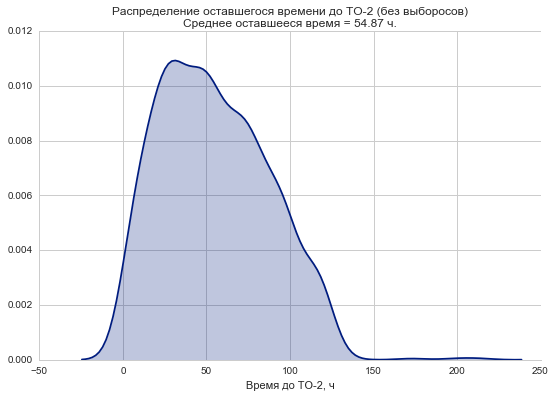

In [49]:
info_cols = ['loco', 'ser_name', 'oper_location', 'oper_time', 'dts', 'tts']
loco_n = loco_info.loco.drop_duplicates().count()
loco_info.dts.fillna(-1, inplace=True)
loco_info.tts.fillna(-1, inplace=True)
no_ts = loco_info[(loco_info.dts == -1) | (loco_info.tts == -1)]
no_ts_n = no_ts.loco.drop_duplicates().count()
outliers = loco_info[loco_info.tts.apply(lambda x: np.abs(x - loco_info.tts.mean()) > 3 * loco_info.tts.std())]
outliers_n = outliers.loco.drop_duplicates().count()
#print('Всего локомотивов без tts/dts: %d (%.2f%%)' % (no_ts_n, 100 * no_ts_n / loco_n))
sns.set(style='whitegrid', context='notebook', palette='dark')
ax = sns.distplot(loco_info[loco_info.loco.isin(outliers.loco) == False].tts / 3600, hist=False, kde_kws={'shade':True})
ax.set(title='Распределение оставшегося времени до ТО-2 (без выборосов)\nСреднее оставшееся время = %.2f ч.'
       % (loco_info[loco_info.loco.isin(outliers.loco) == False].tts.mean() / 3600), xlabel='Время до ТО-2, ч')
sns.despine()

if no_ts_n == 0:
    add_line('Для всех локомотивов заданы время и пробег до ТО-2')    
    result['2.3.3'] = True
else:
    add_header('Всего %d локомотивов, для которых не заданы время или пробег до ТО-2. Примеры:')
    add_line(no_ts[info_cols])
    result['2.3.3'] = False
add_line('Всего локомотивов с замененными временем/пробегом до ТО-2: %d (%.2f%%)' % (outliers_n, 100 * outliers_n / loco_n))

<a id='234'></a>
### 2.3.4. Связь локомотива с поездом [ToC](#toc)

In [50]:
add_header('2.3.4. Связь локомотива с поездом', h=3, p=False)

In [51]:
info_cols = ['loco', 'ser_name', 'oper_time', 'st_from_name', 'st_to_name', 'train']
loco_info['link'] = list(zip(loco_info.st_from, loco_info.st_to))
loco_info['train_oper'] = loco_info.train.map(train_info.set_index('train').oper)
loco_info['train_location'] = loco_info.train.map(train_info.set_index('train').oper_location)
loco_info['train_oper_time'] = loco_info.train.map(train_info.set_index('train').oper_time)
loco_info['train_oper_time_f'] = loco_info.train_oper_time.apply(lambda x: nice_time(x))
loco_info.train.fillna('-1', inplace=True)
loco_dep = loco_info[loco_info.st_from != '-1']
loco_dep_correct = loco_dep[loco_dep.link.isin(links.link)]
loco_dep_correct_n = colcount(loco_dep_correct, 'loco')
add_line('Всего %d локомотивов на корректных участках' % loco_dep_correct_n)

Всего 287 локомотивов на корректных участках


In [52]:
info_cols = ['loco', 'ser_name', 'oper_time', 'st_from_name', 'st_to_name', 'train']
loco_train = loco_info[(loco_info.train != '-1')]
loco_dep_train_nan = loco_info[(loco_info.train != '-1') & (loco_info.train.isin(train_info.train) == False)]
if loco_dep_train_nan.empty:
    add_line('Нет локомотивов со ссылкой на несуществующий поезд')
    result['2.3.4'] = True
else:
    loco_dep_train_nan_n = colcount(loco_dep_train_nan, 'loco')
    add_header('FAIL: Всего %d локомотивов со ссылкой на несуществующий поезд:' % loco_dep_train_nan_n)
    add_line(loco_dep_train_nan.sort_values('number')\
             .head(10 if loco_dep_train_nan_n > 20 else loco_dep_train_nan_n)[info_cols])
    result['2.3.4'] = False

FAIL: Всего 4 локомотивов со ссылкой на несуществующий поезд:
         loco ser_name   oper_time st_from_name    st_to_name train
 200200063146     ВЛ65  1465800960      ТАКСИМО      КАЗАНКАН      
 200200087343    3ЭС5К  1465797300       ТАЙШЕТ         ТОРЕЯ      
 200200065553   2ТЭ10В  1465786800          NaN  ВОЛОЧАЕВКА I      
 200200082072   2ТЭ10В  1465786800          NaN  ВОЛОЧАЕВКА I      


In [53]:
info_cols = ['loco', 'oper_location', 'st_from_name', 'st_to_name', 'train', 'train_oper', 'train_location']
loco_dep_location_fail = loco_train[(loco_train.loco.isin(loco_dep_train_nan.loco) == False)
                         & (loco_train.train_location != loco_train.oper_location)][info_cols]
if loco_dep_location_fail.empty:
    add_line('Нет локомотивов со ссылкой на поезд с несовпадающим местоположением поезда')
    result['2.3.4'] = result['2.3.4'] & True
else:
    loco_dep_location_fail_n = colcount(loco_dep_location_fail, 'loco')
    add_header('FAIL: Всего %d локомотивов со ссылкой поезд с несовпадающим местоположением поезда:' % loco_dep_location_fail_n)
    add_line(loco_dep_location_fail[info_cols].head(10 if loco_dep_location_fail_n > 20 else loco_dep_location_fail_n))
    result['2.3.4'] = result['2.3.4'] & False

FAIL: Всего 1 локомотивов со ссылкой поезд с несовпадающим местоположением поезда:
         loco oper_location st_from_name st_to_name         train train_oper                train_location
 200200091620    2000037398          NaN        NaN  220200652515     depart  ['2000036710', '2000036700']


In [54]:
info_cols = ['loco', 'oper_location', 'oper_time', 'st_from_name', 'st_to_name', 
             'train', 'train_oper', 'train_location', 'train_oper_time']
pd.set_option('display.max_colwidth', 25)
loco_dep_time_fail = loco_train[(loco_train.loco.isin(loco_dep_train_nan.loco) == False)
                                     & (loco_train.train_location == loco_train.oper_location)
                                     & (loco_train.train_oper_time != loco_train.oper_time)][info_cols]

if loco_dep_time_fail.empty:
    add_line('Нет локомотивов со ссылкой на поезд с несовпадающим временем операции')
    result['2.3.4'] = result['2.3.4'] & True
else:
    loco_dep_time_fail_n = colcount(loco_dep_time_fail, 'loco')
    add_header('FAIL: Всего %d локомотивов со ссылкой на поезд с несовпадающим временем операции:' % loco_dep_time_fail_n)
    add_line(loco_dep_time_fail.head(10 if loco_dep_time_fail_n > 20 else loco_dep_time_fail_n)[info_cols])
    result['2.3.4'] = result['2.3.4'] & False

FAIL: Всего 1 локомотивов со ссылкой на поезд с несовпадающим временем операции:
         loco oper_location   oper_time st_from_name st_to_name         train train_oper train_location  train_oper_time
 200200106322    2000035642  1465803540          NaN        NaN  200251470453     arrive     2000035642       1465803000


<a id='235'></a>
### 2.3.5. Связь локомотива с бригадой [ToC](#toc)

In [55]:
add_header('2.3.5. Связь локомотива с бригадой', h=3, p=False)

In [56]:
lteams = team_info[team_info.loco != '-1'].groupby('loco').team.unique()
loco_info['all_teams'] = loco_info.loco.map(lteams)
loco_info['teams_n'] = loco_info.all_teams.apply(lambda x: 0 if type(x) == float else len(x))

In [57]:
info_cols = ['loco', 'oper_location', 'oper_time', 'st_from_name', 'st_to_name']
pd.set_option('display.max_colwidth', 40)
loco_dep = loco_info[(loco_info.st_from != '-1') | (loco_info.st_to != '-1')]
loco_dep_n = colcount(loco_dep, 'loco')
loco_dep_no_team = loco_dep[loco_dep.loco.isin(team_info.loco) == False]
if loco_dep_no_team.empty:
    add_header('Нет локомотивов, для которых не передана бригада со ссылкой на этот локомотив')
    result['2.3.5'] = True    
else:
    loco_dep_no_team_n = colcount(loco_dep_no_team, 'loco')
    add_header('FAIL: Всего %d локомотивов на участках (%.2f%%), для которых не передана бригада со ссылкой на этот локомотив'
         % (loco_dep_no_team_n, 100 * loco_dep_no_team_n / loco_dep_n))
    add_line(loco_dep_no_team[info_cols].head(10 if loco_dep_no_team_n > 20 else loco_dep_no_team_n))
    result['2.3.5'] = False
pd.set_option('display.max_colwidth', 30)

FAIL: Всего 11 локомотивов на участках (3.72%), для которых не передана бригада со ссылкой на этот локомотив
         loco                 oper_location   oper_time              st_from_name       st_to_name
 200200099503  ['2000038072', '2000038088']  1465751700                    АМАЗАР  ЕРОФЕЙ ПАВЛОВИЧ
 200200082964  ['2000037306', '2000037236']  1465768860                   МЫСОВАЯ        БАЙКАЛЬСК
 200200048802  ['2000035954', '2000035966']  1465756260                       УЯР        ЗАОЗЕРНАЯ
 200206066989  ['2000038060', '2000038048']  1465785000                    МОГОЧА      КСЕНЬЕВСКАЯ
 200200052051  ['2000038060', '2000038072']  1465773300                    МОГОЧА           АМАЗАР
 200200035486  ['2000037674', '2000037726']  1465739700                    КАДАЛА           ЛЕСНАЯ
 200200139996  ['2000037632', '2000037642']  1465794780                    МОГЗОН         ТУРГУТУЙ
 200200094780  ['2000038760', '2000038748']  1465788780            СПАССК-ДАЛЬНИЙ         ШМАКОВКА


In [58]:
info_cols = ['loco', 'oper_time', 'st_from_name', 'st_to_name', 'all_teams', 'teams_n']
pd.set_option('display.max_colwidth', 35)
dupl_teams = loco_dep[loco_dep.teams_n > 1]
if dupl_teams.empty:
    add_header('Для всех локомотивов на участках есть ровно одна бригада со ссылкой на этот локомотив')
    result['2.3.5'] = result['2.3.5'] & True
else:
    dupl_teams_n = colcount(dupl_teams, 'loco')
    add_header('Всего %d локомотивов на участках (%.2f%%), для которых есть больше одной бригады со ссылкой на этот локомотив'
         % (dupl_teams_n, 100 * dupl_teams_n / loco_dep_n))
    add_line(dupl_teams[info_cols].head(10 if dupl_teams_n > 20 else dupl_teams_n))
    result['2.3.5'] = result['2.3.5'] & False
pd.set_option('display.max_colwidth', 30)

Всего 16 локомотивов на участках (5.41%), для которых есть больше одной бригады со ссылкой на этот локомотив
         loco   oper_time           st_from_name                          st_to_name                     all_teams  teams_n
 200200095664  1465803600   КОМСОМОЛЬСК-НА-АМУРЕ  КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  [200200280282, 200200280329]        2
 200200101679  1465803900              КАРЫМСКАЯ                              ЧИТА I  [200200132948, 200200275385]        2
 200200086598  1465749300                 ЗИЛОВО                             ЖИРЕКЕН  [200200190089, 200200166791]        2
 200200085604  1465803840                   КИЖА                              ГОРХОН  [200200107456, 200200263004]        2
 200200082072  1465786800                    NaN                        ВОЛОЧАЕВКА I  [200200260537, 200200256431]        2
 200200096421  1465803060               УЛАН-УДЭ                             МЫСОВАЯ  [200200245816, 200200153440]        2
 200200048385  14658033

In [59]:
# Проверку на совпадение местоположения и времени операции будем делать от бригад, поскольку у локомотивов может быть 2+ бригад
# во входных данных

team_info['loco_location'] = team_info.loco.map(loco_info.set_index('loco').oper_location)
team_info['loco_oper_time'] = team_info.loco.map(loco_info.set_index('loco').oper_time)
team_info['loco_oper_time_f'] = team_info.loco_oper_time.apply(lambda x: nice_time(x))

In [60]:
info_cols = ['loco', 'loco_location', 'team', 'oper_location', 'state']
pd.set_option('display.max_colwidth', 50)
loco_team_location_fail = team_info[(team_info.loco != '-1') & (team_info.oper_location != team_info.loco_location)]
if loco_team_location_fail.empty:
    add_header('Для всех локомотивов на участках местоположение соответствующей бригады совпадает с местоположением локомотива')
    result['2.3.5'] = result['2.3.5'] & True
else:
    loco_team_location_fail_n = colcount(loco_team_location_fail, 'loco')
    add_header('Всего %d локомотивов на участках (%.2f%%) с отличающимся местоположением бригады. Примеры:' 
              % (loco_team_location_fail_n, 100 * loco_team_location_fail_n / loco_dep_n))
    add_line(loco_team_location_fail[info_cols].head(10 if loco_team_location_fail_n > 20 else loco_team_location_fail_n))
    result['2.3.5'] = result['2.3.5'] & False
    loco_team_location_fail[info_cols].to_csv('loco_team_location_fail.csv', encoding='utf-8-sig', sep=';', index=None)
pd.set_option('display.max_colwidth', 30)

Всего 49 локомотивов на участках (16.55%) с отличающимся местоположением бригады. Примеры:
         loco                 loco_location          team                 oper_location state
 200200069939                    2000036604  200200120526                    2000036710     5
 200200105280                    2000038904  200200101170  ['2000038894', '2000038884']     1
 200200095664  ['2000038372', '2000038358']  200200280282                    2000038372     9
 200200082072  ['2000038434', '2000038468']  200200260537                    2000038434     9
 200200084676                    2000038060  200200097053                    2000037980     9
 200200030251                    2000037980  200200226288                    2000038060     9
 200200093242                    2000036710  200200260830                    2000036604     9
 200200055783                    2000036604  200200128540                    2000035782     9
 200200080787                    2000036796  200200256037      

In [61]:
info_cols = ['loco', 'loco_location', 'loco_oper_time', 'team', 'oper_location', 'oper_time']
loco_team_time_fail = team_info[(team_info.loco != '-1') & (team_info.oper_time != team_info.loco_oper_time)]
if loco_team_time_fail.empty:
    add_header('Для всех локомотивов на участках время операции соответствующей бригады совпадает с временем у локомотива')
    result['2.3.5'] = result['2.3.5'] & True
else:
    loco_team_time_fail_n = colcount(loco_team_time_fail, 'loco')
    add_header('Всего %d локомотивов на участках (%.2f%%) с отличающимся временем операции бригады. Примеры:' 
              % (loco_team_time_fail_n, 100 * loco_team_time_fail_n / loco_dep_n))
    add_line(loco_team_time_fail[info_cols].head(10 if loco_team_time_fail_n > 20 else loco_team_time_fail_n))
    result['2.3.5'] = result['2.3.5'] & False

Всего 78 локомотивов на участках (26.35%) с отличающимся временем операции бригады. Примеры:
         loco                 loco_location  loco_oper_time          team                 oper_location   oper_time
 200200071188                    2000037186      1465801020  200200223977                    2000037186  1465802400
 200200069939                    2000036604      1465734900  200200120526                    2000036710  1465802400
 200200105280                    2000038904      1465780800  200200101170  ['2000038894', '2000038884']  1465802700
 200200095664  ['2000038372', '2000038358']      1465803600  200200280282                    2000038372  1465772100
 200200080787                    2000036796      1465799400  200200223941                    2000036796  1465803000
 200200082072  ['2000038434', '2000038468']      1465786800  200200260537                    2000038434  1465781400
 200200084676                    2000038060      1465770720  200200097053                    20

<a id='236'></a>
### 2.3.6. Наличие локомотивов на всех тяговых плечах [ToC](#toc)

In [62]:
add_header('2.3.6. Наличие локомотивов на всех тяговых плечах', h=3, p=False)

In [63]:
all_regs = stations.loco_region.unique()
loco_info['regions_eval'] = loco_info.regions.apply(literal_eval)
regs_in_loco = np.unique(np.concatenate(loco_info.regions_eval))
reg_no_loco = [reg for reg in all_regs if str(reg) not in regs_in_loco]
if len(reg_no_loco) == 0:
    add_header('На всех тяговых плечах есть локомотивы')
    result['2.3.6'] = True
else:
    add_header('Всего %d тяговых плеч без приписанных к ним локомотивов. Тяговые плечи:' % len(reg_no_loco))
    for reg in reg_no_loco:
        add_line('Region: %s, stations: %s' % (reg, stations[stations.loco_region == reg].name.values))
        result['2.3.6'] = False

Всего 2 тяговых плеч без приписанных к ним локомотивов. Тяговые плечи:
Region: 2002119284, stations: ['УЖУР' 'ТИСИН' 'ОРОСИТЕЛЬНЫЙ' 'ТИГЕЙ' 'ТУМАННЫЙ' 'ЕРБИНСКАЯ' 'ТАШЕБА'
 'ЧЕРНОГОРСКИЕ КОПИ' 'АЧИНСК II' 'ПРИГОРОДНЫЙ' 'КРАСНАЯ СОПКА' 'СОН'
 'ДУБИНИНО' 'ШУШЬ' 'УЛУЙ' 'ШАРЫПОВО' 'НАЗАРОВО' 'АБАКАН' 'БАЗЫР'
 'КИЯ-ШАЛТЫРЬ']
Region: 2002119282, stations: ['АСКИЗ' 'АБАЗА']


<a id='237'></a>
### 2.3.7. Покрытие локомотивами всех участков планирования [ToC](#toc)

In [64]:
add_header('2.3.7. Покрытие локомотивами всех участков планирования', h=3, p=False)

In [65]:
links['has_loco'] = links.link_regs.apply(lambda x: any(str(reg) in regs_in_loco for reg in x) if type(x) != float else False)
links['link_name'] = list(zip(links.st_from_name, links.st_to_name))
links_no_loco = links[links.has_loco == False]
if links_no_loco.empty:
    add_header('На всех участках планирования есть хотя бы один локомотив, который может там работать')
    result['2.3.7'] = True
else:
    links_no_loco_n = colcount(links_no_loco, 'link')
    links_n = colcount(links, 'link')
    add_header('Всего %d участков планирования (%.2f%%), для которых нет ни одного локомотива, который мог бы там работать:'
              % (links_no_loco_n, 100 * links_no_loco_n / links_n))
    add_line(links_no_loco.link_name.unique())
    result['2.3.7'] = False

Всего 34 участков планирования (4.56%), для которых нет ни одного локомотива, который мог бы там работать:
[('УЖУР', 'ТИСИН') ('ТУМАННЫЙ', 'ЕРБИНСКАЯ') ('ЕРБИНСКАЯ', 'ТУМАННЫЙ')
 ('АСКИЗ', 'АБАЗА') ('УЖУР', 'КРАСНАЯ СОПКА') ('ЕРБИНСКАЯ', 'ОРОСИТЕЛЬНЫЙ')
 (nan, 'БИРА') ('СОН', 'ТУМАННЫЙ') ('ТУМАННЫЙ', 'СОН') ('БИРОФЕЛЬД', nan)
 (nan, nan) ('КРАСНАЯ СОПКА', 'УЖУР') ('МАХАЛИНО', nan)
 ('ДУБИНИНО', 'ШУШЬ') (nan, 'БИРОФЕЛЬД') ('ТИСИН', 'УЖУР')
 ('ШАРЫПОВО', 'ШУШЬ') ('ОРОСИТЕЛЬНЫЙ', 'ЕРБИНСКАЯ') ('ШАРЫПОВО', 'БАЗЫР')
 ('БИРА', nan) ('БАЗЫР', 'ШАРЫПОВО') ('ШУШЬ', 'ДУБИНИНО')
 (nan, 'ВОЛОЧАЕВКА I') ('КРАСНАЯ СОПКА', 'ШУШЬ')
 ('ДУБИНИНО', 'КИЯ-ШАЛТЫРЬ') ('КИЯ-ШАЛТЫРЬ', 'ДУБИНИНО') ('СОН', 'ТИСИН')
 ('ШУШЬ', 'ШАРЫПОВО') ('АБАЗА', 'АСКИЗ') ('ВОЛОЧАЕВКА I', nan)
 ('ТИСИН', 'СОН') (nan, 'МАХАЛИНО') ('ШУШЬ', 'КРАСНАЯ СОПКА')]


In [66]:
big_stations = stations[stations.norm_time != 0].drop_duplicates('station')
big_links_no_loco = links_no_loco[links_no_loco.st_from.isin(big_stations.station)]
if big_links_no_loco.empty:
    add_header('На всех участках планирования от крупных станций есть хотя бы один локомотив, который может там работать')    
else:
    big_links_no_loco_n = colcount(big_links_no_loco, 'link')    
    add_header('Всего %d участков планирования от крупных станций(%.2f%%), ' 
               % (big_links_no_loco_n, 100 * big_links_no_loco_n / links_n) 
               + 'для которых нет ни одного локомотива, который мог бы там работать:')
    add_line(big_links_no_loco.link_name.unique())    

Всего 2 участков планирования от крупных станций(0.27%), для которых нет ни одного локомотива, который мог бы там работать:
[('УЖУР', 'ТИСИН') ('УЖУР', 'КРАСНАЯ СОПКА')]


<a id='238'></a>
### 2.3.8. Проверка корректности типа локомотива [ToC](#toc)

In [67]:
add_header('2.3.8. Проверка корректности типа локомотива', h=3, p=False)

In [68]:
good_series = ['2ТЭ10', '3ТЭ10', '2ЭС5К', '3ЭС5К', 'ВЛ80', 'ВЛ85']
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
loco_info['is_good_ser'] = loco_info.ser_name.apply(lambda x: any(ser in x for ser in good_series) \
                                                    if type(x) != float else False)
bad_locos = loco_info[loco_info.ltype != loco_info.is_good_ser][['loco', 'ser_name', 'ltype', 'is_good_ser']]
if bad_locos.empty:
    add_header('Для всех локомотивов тип указан верно')
    result['2.3.8'] = True
else:
    add_header('Всего %d случаев, когда для локомотива неправильно определяется тип (грузовой или нет):' 
               % colcount(bad_locos, 'loco'))
    add_line(bad_locos.groupby(['is_good_ser', 'ltype']).ser_name.value_counts())
    result['2.3.8'] = False

Всего 53 случаев, когда для локомотива неправильно определяется тип (грузовой или нет):
is_good_ser  ltype  ser_name
False        1      2ТЭ25А      20
True         0      2ТЭ10МК     10
                    2ТЭ10М       8
                    2ТЭ10В       6
                    ВЛ80Т        3
                    2ТЭ10У       2
                    2ТЭ10УТ      1
                    2ЭС5К        1
                    3ЭС5К        1


<a id='24'></a>
## 2.4. Тесты по бригадам [ToC](#toc)

In [69]:
add_header('2.4. Тесты по бригадам', h=2, p=False)

<a id='241'></a>
### 2.4.1. Простые тесты [ToC](#toc)

In [70]:
TEAM_EXPECTED_NUMBER = 3000

In [71]:
result['2.4.1'] = True
team_n = colcount(team_info, 'team')
if team_n > TEAM_EXPECTED_NUMBER:
    add_line('Всего %d бригад передано в планировщик' % team_n)
    result['2.4.1'] = result['2.4.1'] & True    
else:
    add_line('FAIL: в планировщик передано мало бригад (%d вместо ожидаемых %d)' % (team_n, TEAM_EXPECTED_NUMBER))
    result['2.4.1'] = result['2.4.1'] & False

Всего 3554 бригад передано в планировщик


<a id='242'></a>
### 2.4.2. Корректность местоположения и станций явки [ToC](#toc)

In [72]:
add_header('2.4.2. Корректность местоположения и станций явки', h=3, p=False)

In [73]:
cols = ['team', 'number', 'depot_st', 'loco', 'state', 'ready_type', 'is_depot_st']

team_info['is_depot_st'] = team_info.depot_st.isin(stations.station)
add_header('Всего %d бригад со станцией явки после домашнего отдыха, отсутствующей в справочнике станций. Примеры:' 
      % len(team_info.loc[(team_info.depot_st != '-1') & (team_info.is_depot_st == False)].index))
add_line(team_info[(team_info.depot_st != '-1') & (team_info.is_depot_st == False)].head()[cols])

cols = ['team', 'number', 'return_st', 'loco', 'state', 'ready_type', 'is_return_st']
team_info['is_return_st'] = team_info.return_st.isin(stations.station)
add_header('Всего %d бригад с несуществующей станцией явки после отдыха в пункте оборота (показаны первые 5):' 
      % len(team_info.loc[(team_info.return_st != '-1') & (team_info.is_return_st == False)].index))
add_line(team_info[(team_info.return_st != '-1') & (team_info.is_return_st == False)].head()[cols])

cols = ['team', 'number', 'oper_location', 'loc_name', 'loco', 'state', 'ready_type', 'is_oper_st']
team_info['is_oper_st'] = team_info.oper_location.isin(stations.station)
add_header('Всего %d бригад с несуществующей станцией операции (показаны первые 5):' 
      % len(team_info.loc[(team_info.st_from == '-1') & (team_info.is_oper_st == False)].index))
add_line(team_info[(team_info.st_from == '-1') & (team_info.is_oper_st == False)].head()[cols])

cols = ['team', 'number', 'st_from', 'st_to', 'loc_name', 'loco', 'state', 'ready_type']
pd.set_option('display.max_colwidth', 45)
team_info['link'] = list(zip(team_info.st_from, team_info.st_to))
bad_team_link = team_info[((team_info.st_from != '-1') | (team_info.st_to != '-1')) 
                          & (team_info.link.isin(links.link) == False)]
add_header('Всего %d бригад на участках, для которых участок не задан в справочнике. Примеры:' % colcount(bad_team_link, 'team'))
add_line(bad_team_link.head()[cols])
pd.set_option('display.max_colwidth', 30)

Всего 17 бригад со станцией явки после домашнего отдыха, отсутствующей в справочнике станций. Примеры:
         team      number    depot_st          loco state ready_type is_depot_st
 200200223737  9601011930  2000038434            -1     3      depot       False
 200200184936  9602008675  2000038692            -1     0      depot       False
 200200256431  9601010135  2000038422  200200082072     1      depot       False
 200200199948  9601011919  2000038434            -1     3      depot       False
 200200192690  8312002048  2001930894  200200085645     6      depot       False
Всего 15 бригад с несуществующей станцией явки после отдыха в пункте оборота (показаны первые 5):
         team      number   return_st          loco state ready_type is_return_st
 200200170975  9611044416  2000036310            -1     4      depot        False
 200202498296  9214006199  2000036264            -1     4      depot        False
 200200251120  9206003879  2000036930            -1     4      depo

In [74]:
bad_team_link[['team', 'loco', 'state']]

,team,loco,state
7,200200277788,-1,0
53,200200260560,200200102217,1
72,200200224604,200200090376,1
82,200200067532,-1,0
108,200200216057,-1,0
160,200200108280,-1,0
191,200200157368,-1,0
224,200200197789,-1,0
346,200200102632,-1,0
348,200200216784,-1,0


<a id='243'></a>
### 2.4.3. Корректность данных по бригадам в зависимости от состояния [ToC](#toc)

In [75]:
add_header('2.4.3. Корректность данных по явке бригад в зависимости от состояния', h=3, p=False)

In [76]:
team_info['depot_time_f'] = team_info.depot_time.apply(lambda x: nice_time(x))
team_info['return_time_f'] = team_info.depot_time.apply(lambda x: nice_time(x))
team_info['rest_time_f'] = team_info.depot_time.apply(lambda x: nice_time(x))
team_info['depot_st_name'] = team_info.depot_st.map(st_names.name)
team_info['return_st_name'] = team_info.return_st.map(st_names.name)
result['2.4.3'] = True

<a id='2431'></a>
#### 2.4.3.1. Бригада следует пассажиром (state = 0) [ToC](#toc)

In [77]:
result['2.4.3.1'] = True
# state = 0. Это бригады, следующие пассажирами. Для них предполагается наличие участка планирования и, возможно, локомотива
t_state0 = team_info.loc[team_info.state == '0']
t_state0_n = colcount(t_state0, 'team')
t_state0_wo_link = t_state0[t_state0.st_from == '-1']
t_state0_wo_link_n = colcount(t_state0_wo_link, 'team')
if t_state0_n != 0:
    if t_state0_wo_link_n != 0:
        add_header('FAIL: Всего %d бригад в состоянии 0, из них не на перегонах %d (%.2f%%) (показаны первые 5):' \
              % (t_state0_n, t_state0_wo_link_n, 100 * t_state0_wo_link_n / t_state0_n))
        add_line(t_state0_wo_link[['team', 'state', 'st_from', 'st_to', 'loco']].head())
        result['2.4.3.1'] = result['2.4.3.1'] & False
    else:
        add_header('Все бригады в состоянии 0 находятся на перегонах.')
        result['2.4.3.1'] = result['2.4.3.1'] & True
else:
    add_header('WARN!! Всего бригад пассажирами', t_state1_n)        

Все бригады в состоянии 0 находятся на перегонах.


In [78]:
ready_cols = ['team', 'ready_type', 'depot_st', 'depot_st_name', 'depot_time_f', 
              'return_st', 'return_st_name', 'return_time_f', 'rest_time_f']
team_info['is_dgr'] = (team_info.depot_time > team_info.return_time)
team_info['is_rgd'] = (team_info.return_time > team_info.depot_time) & (team_info.return_time > team_info.rest_time)
team_info['is_restgdr'] = (team_info.rest_time > team_info.depot_time) & (team_info.rest_time > team_info.return_time)

In [79]:
t_state0_rdepot_fail = team_info.loc[(team_info.state == '0') &
              (team_info.ready_type == 'depot') &
              (team_info.is_dgr == False), ready_cols]
if not t_state0_rdepot_fail.empty:
    add_header('FAIL: Всего %d бригад в состоянии 0 с явкой в депо и временем явки меньше времени явки в пункте оборота' \
          % colcount(t_state0_rdepot_fail, 'team'))
    add_line(t_state0_rdepot_fail.head())
    result['2.4.3.1'] = result['2.4.3.1'] & False
else:
    add_header('У всех бригад в состоянии 0 и последней явкой в депо время явки в депо больше времени явки в пункте оборота.')
    result['2.4.3.1'] = result['2.4.3.1'] & True
    
t_state0_rreturn_fail = team_info.loc[(team_info.state == '0') &
              (team_info.ready_type == 'return') &
              (team_info.is_rgd == False), ready_cols]
if not t_state0_rreturn_fail.empty:
    add_header('''FAIL: Всего %d бригад в состоянии 0 с явкой в пункте оборота
          и временем явки не больше времени явки в депо или времени начала отдыха:''' \
          % len(t_state0_rreturn_fail.index))
    add_line(t_state0_rreturn_fail)
    result['2.4.3.1'] = result['2.4.3.1'] & False
else:
    add_header('У всех бригад в состоянии 0 и последней явкой в пункте оборота время ' + 
               'явки в пункте оборота больше времени явки в депо.')
    result['2.4.3.1'] = result['2.4.3.1'] & True

У всех бригад в состоянии 0 и последней явкой в депо время явки в депо больше времени явки в пункте оборота.
FAIL: Всего 3 бригад в состоянии 0 с явкой в пункте оборота
          и временем явки не больше времени явки в депо или времени начала отдыха:
         team ready_type    depot_st depot_st_name   depot_time_f   return_st return_st_name  return_time_f    rest_time_f
 200200216057     return          -1           NaN                         -1            NaN                              
 200200208676     return  2000037398      УЛАН-УДЭ  Jun 12, 19:00  2000037604          ХИЛОК  Jun 12, 19:00  Jun 12, 19:00
 200200194932     return  2000036256           NaN  Jun 08, 23:50  2000036256            NaN  Jun 08, 23:50  Jun 08, 23:50


<a id='2432'></a>
#### 2.4.3.2. Бригада следует на локомотиве (state = 1) [ToC](#toc)

In [80]:
result['2.4.3.2'] = True

In [81]:
# state = 1. Это бригады, следующие с локомотивами. Для них предполагается наличие участка планирования и локомотива
cols = ['team', 'state', 'st_from_name', 'st_to_name', 'loco']
t_state1 = team_info.loc[team_info.state == '1']
t_state1_n = len(t_state1.index)
t_state1_wo_link_loco = t_state1.loc[(t_state1.st_from == '1') | (t_state1.loco == '-1')]
t_state1_wo_link_loco_n = len(t_state1_wo_link_loco.index)
if t_state1_n != 0:
    if t_state1_wo_link_loco_n != 0:
        add_header('FAIL: Всего %d бригад в состоянии 1, из них не на перегонах или без локомотивов %d (%.2f%%). Примеры:'
              % (t_state1_n, t_state1_wo_link_loco_n, 100 * t_state1_wo_link_loco_n/t_state1_n))
        add_line(t_state1_wo_link_loco[cols].head())
        result['2.4.3.2'] = result['2.4.3.2'] & False
    else:
        add_header('Все бригады в состоянии 1 находятся на перегонах с локомотивами.')
        result['2.4.3.2'] = result['2.4.3.2'] & True
else:
    add_header('WARN!! Во входных данных нет бригад в состоянии 1.')

Все бригады в состоянии 1 находятся на перегонах с локомотивами.


In [82]:
t_state1_rdepot_fail = team_info[(team_info.state == '1') & (team_info.ready_type == 'depot') & (team_info.is_dgr == False)]
if not t_state1_rdepot_fail.empty:
    add_header('FAIL: Всего %d бригад в состоянии 1 с явкой в депо и временем явки меньше времени явки в пункте оборота'
          % len(t_state1_rdepot_fail.index))
    add_line(t_state1_rdepot_fail[ready_cols])
    result['2.4.3.2'] = result['2.4.3.2'] & False
else:
    add_header('Все бригады в состоянии 1 и явкой в депо имеют время явки в депо больше времени явки в пункте оборота')
    result['2.4.3.2'] = result['2.4.3.2'] & True

Все бригады в состоянии 1 и явкой в депо имеют время явки в депо больше времени явки в пункте оборота


In [83]:
t_state1_rreturn_fail = team_info[(team_info.state == '1') & (team_info.ready_type == 'return') & (team_info.is_rgd == False)]
if not t_state1_rreturn_fail.empty:
    add_header('''FAIL: Всего %d бригад в состоянии 1, с явкой в пункте оборота
          и временем явки не больше времени явки в депо или времени начала отдыха. Примеры:''' 
            % len(t_state1_rreturn_fail.index))
    add_line(t_state1_rreturn_fail.head()[ready_cols])
    result['2.4.3.2'] = result['2.4.3.2'] & False
else:
    add_header('У всех бригад в состоянии 1 и с явкой в пункте оборота времена явок корректные')
    result['2.4.3.2'] = result['2.4.3.2'] & True

FAIL: Всего 13 бригад в состоянии 1, с явкой в пункте оборота
          и временем явки не больше времени явки в депо или времени начала отдыха. Примеры:
         team ready_type depot_st depot_st_name depot_time_f return_st return_st_name return_time_f rest_time_f
 200200143512     return       -1           NaN                     -1            NaN                          
 200200248325     return       -1           NaN                     -1            NaN                          
 200200181992     return       -1           NaN                     -1            NaN                          
 200200128271     return       -1           NaN                     -1            NaN                          
 200200262751     return       -1           NaN                     -1            NaN                          


<a id='2433'></a>
#### 2.4.3.3. Бригада находится на домашнем отдыхе или на явке в депо приписки (state = 2 или 3) [ToC](#toc)

In [84]:
result['2.4.3.3'] = True

In [85]:
# state = 2, 3. Это бригады с явкой в депо приписки или находящиеся на домашнем отдыхе
cols = ['team', 'number', 'state', 'oper_location', 'st_from', 'st_to', 'loco']
team_info.loco.fillna('-1', inplace=True)
t_state2 = team_info.loc[team_info.state.isin(['2', '3'])]
t_state2_n = len(t_state2.index)
t_state2_wo_st = t_state2.loc[(t_state2.st_from != '-1') | (t_state2.st_to != '-1') | (t_state2.loco != '-1')]
t_state2_wo_st_n = len(t_state2_wo_st.index)
if t_state2_n != 0:
    if t_state2_wo_st_n != 0:
        add_header('FAIL: Всего %d бригад в состоянии 2 или 3, из них не на станции или с локомотивом %d (%.2f%%). Примеры:'
              % (t_state2_n, t_state2_wo_st_n, 100 * t_state2_wo_st_n/t_state2_n))
        add_line(t_state2_wo_st[cols].head())
        result['2.4.3.3'] = result['2.4.3.3'] & False
    else:
        add_header('Все бригады (%d) в состоянии 2 или 3 имеют корректное местоположение без ссылки на локомотив.' 
                   % t_state2_n)
        result['2.4.3.3'] = result['2.4.3.3'] & True
else:
    add_header('WARN!! Нет бригад в состоянии 2 или 3')

Все бригады (1853) в состоянии 2 или 3 имеют корректное местоположение без ссылки на локомотив.


In [86]:
t_state2_rr = t_state2.loc[t_state2.ready_type == 'return']
t_state2_rr_n = len(t_state2_rr.index)
t_state2_rdepot_fail = team_info[(team_info.state.isin(['2', '3'])) &
              (team_info.ready_type == 'depot') & (team_info.is_dgr == False)]
if t_state2_rr_n != 0:
    add_header('FAIL: Всего %d бригад на явке в депо (state = 2, 3), но с неправильной последней явкой в fact_team_ready:' \
         % t_state2_rr_n)
    add_line(t_state2_rr[ready_cols].head())
    result['2.4.3.3'] = result['2.4.3.3'] & False
else:
    add_header('Все бригады в состоянии 2 или 3 имеют последнюю явку в депо.')
    result['2.4.3.3'] = result['2.4.3.3'] & True
    
if not t_state2_rdepot_fail.empty:
    add_header('FAIL: Всего %d бригад в состоянии 2 или 3 и временем явки меньше времени явки в пункте оборота. Примеры:' \
          % len(t_state2_rdepot_fail.index))
    add_line(t_state2_rdepot_fail.head())
    result['2.4.3.3'] = result['2.4.3.3'] & False
else:
    add_header('У всех бригад в состоянии 2 или 3 время явки в депо больше времени явки в пункте оборота.')
    result['2.4.3.3'] = result['2.4.3.3'] & True

Все бригады в состоянии 2 или 3 имеют последнюю явку в депо.
У всех бригад в состоянии 2 или 3 время явки в депо больше времени явки в пункте оборота.


<a id='2434'></a>
#### 2.4.3.4. Бригады на отдыхе в пункте оборота (state = 4) [ToC](#toc)

In [87]:
result['2.4.3.4'] = True

In [88]:
cols = ['team', 'state', 'oper_location', 'st_from', 'st_to', 'loco']
team_info['rest_lag'] = np.round((current_time - team_info.rest_time) / 3600, 2)
team_info['work_time'] = np.round((team_info.rest_time - team_info.depot_time) / 3600, 2)
team_info['is_big_rest'] = team_info.rest_lag > team_info.work_time

In [89]:
# state = 4. Это бригады на отдыхе в пункте оборота
t_state4 = team_info.loc[team_info.state == '4']
t_state4_n = len(t_state4.index)
t_state4_wo_st = t_state4.loc[(t_state4.st_from != '-1') | (t_state4.st_to != '-1') | (t_state4.loco != '-1')]
t_state4_wo_st_n = len(t_state4_wo_st.index)
if t_state4_n != 0:
    if t_state4_wo_st_n != 0:
        add_header('FAIL: Всего %d бригад на отдыхе, из них не на станции или с локомотивом %d (%.2f%%) (показаны первые 5):'
              % (t_state4_n, t_state4_wo_st_n, 100 * t_state4_wo_st_n/t_state4_n))
        add_line(t_state4_wo_st[cols].head())
        result['2.4.3.4'] = result['2.4.3.4'] & False
    else:
        add_header('Все бригады в состоянии 4 имеют корректное местоположение без ссылки на локомотив.')
        result['2.4.3.4'] = result['2.4.3.4'] & True
else:
    add_header('WARN!! Нет бригад в состоянии 4.')

Все бригады в состоянии 4 имеют корректное местоположение без ссылки на локомотив.


In [90]:
# Поскольку эти бригады только находятся на отдыхе, то явки в пункте оборота не было и последняя явка должна быть в депо
t_state4_rr = t_state4.loc[t_state4.ready_type == 'return']
t_state4_rr_n = len(t_state4_rr.index)
t_state4_rest_fail = team_info.loc[(team_info.state == '4') &              
              (team_info.is_restgdr == False), ready_cols]
if t_state4_rr_n != 0:
    add_header('FAIL: Всего %d бригад в состоянии 4 с неправильной последней явкой в fact_team_ready. Примеры:'
         % t_state4_rr_n)
    add_line(t_state4_rr[ready_cols].head())
    result['2.4.3.4'] = result['2.4.3.4'] & False
else:
    add_header('У всех бригад в состоянии 4 указаны корректные последние явки (в депо приписки)')
    result['2.4.3.4'] = result['2.4.3.4'] & True
    
if not t_state4_rest_fail.empty:
    add_header('FAIL: Всего %d бригад на отдыхе с временем начала отдыха не больше всех времен явок. Примеры:'
          % len(t_state4_rest_fail.index))
    add_line(t_state4_rest_fail.head())
    result['2.4.3.4'] = result['2.4.3.4'] & False
else:
    add_header('У всех бригад в состоянии 4 время начала отдыха больше времен всех явок')
    result['2.4.3.4'] = result['2.4.3.4'] & True

FAIL: Всего 54 бригад в состоянии 4 с неправильной последней явкой в fact_team_ready. Примеры:
         team ready_type    depot_st             depot_st_name   depot_time_f   return_st return_st_name  return_time_f    rest_time_f
 200200203962     return  2000038402                   ОБЛУЧЬЕ  Jun 08, 12:36  2000038624   ХАБАРОВСК II  Jun 08, 12:36  Jun 08, 12:36
 200200241301     return  2000038138               СКОВОРОДИНО  Jun 12, 02:00  2000038102          УРУША  Jun 12, 02:00  Jun 12, 02:00
 200200156145     return  2000038402                   ОБЛУЧЬЕ  Jun 09, 22:11  2000038624   ХАБАРОВСК II  Jun 09, 22:11  Jun 09, 22:11
 200200126086     return  2000037980  ЧЕРНЫШЕВСК-ЗАБАЙКАЛЬСКИЙ  Jun 12, 11:06  2000038016         ЗИЛОВО  Jun 12, 11:06  Jun 12, 11:06
 200200182785     return  2000038600                    ВАНИНО  Jun 09, 15:40  2000038568   ВЫСОКОГОРНАЯ  Jun 09, 15:40  Jun 09, 15:40
У всех бригад в состоянии 4 время начала отдыха больше времен всех явок


In [91]:
big_rest_cols = ['team', 'ready_type', 'depot_st', 'depot_st_name', 'depot_time_f',
                 'rest_time_f', 'rest_lag', 'work_time', 'is_big_rest']
t_state4_big_rest = t_state4.loc[t_state4.is_big_rest == True, big_rest_cols]
t_state4_big_rest_n = len(t_state4_big_rest.index)
percent = 100 * t_state4_big_rest_n / t_state4_n
if (t_state4_big_rest_n > 0):
    add_header('Для %d бригад из %d (%.2f%%) в состоянии 4 сразу превышено максимально разрешенное время отдыха. Примеры:' 
          % (t_state4_big_rest_n, t_state4_n, percent))
    add_line(t_state4_big_rest.head())
    result['2.4.3.4'] = result['2.4.3.4'] & False

Для 48 бригад из 558 (8.60%) в состоянии 4 сразу превышено максимально разрешенное время отдыха. Примеры:
         team ready_type    depot_st                  depot_st_name   depot_time_f    rest_time_f  rest_lag  work_time is_big_rest
 200200157737      depot  2000039048                      УССУРИЙСК  Jun 12, 15:20  Jun 12, 15:20     11.39       7.83        True
 200200225233      depot  2000038358  КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИ...  Jun 12, 11:29  Jun 12, 11:29     12.48      10.60        True
 200200147944      depot  2000038736                         РУЖИНО  Jun 12, 07:20  Jun 12, 07:20     17.38       9.85        True
 200200146713      depot  2000036956          ИРКУТСК-СОРТИРОВОЧНЫЙ  Jun 12, 17:11  Jun 12, 17:11      9.81       7.57        True
 200200173243      depot  2000038904                    СМОЛЯНИНОВО  Jun 12, 12:00  Jun 12, 12:00     11.56      11.00        True


<a id='2435'></a>
#### 2.4.3.5. Бригады с локомотивами на станции (state = 5, 6 или 9) [ToC](#toc)

In [92]:
result['2.4.3.5'] = False

In [93]:
t_state5 = team_info.loc[team_info.state.isin(['5', '6', '9'])]
t_state5_n = len(t_state5.index)
t_state5_wo_st = t_state5.loc[(t_state5.st_from != '-1') | (t_state5.st_to != '-1') | (t_state5.loco == '-1')]
t_state5_wo_st_n = len(t_state5_wo_st.index)
if t_state5_n != 0:
    if t_state5_wo_st_n != 0:
        add_header('''FAIL: Всего %d бригад в состояниях 5, 6 или 9, 
              из них %d (%.2f%%) не на станции или без локомотива (показаны первые 5):''' \
              % (t_state5_n, t_state5_wo_st_n, 100 * t_state5_wo_st_n/t_state5_n))
        add_line(t_state5_wo_st[['team', 'state', 'oper_location', 'st_from', 'st_to', 'loco']].head())
        result['2.4.3.5'] = result['2.4.3.5'] & False
    else:
        add_line('Для всех бригад в состояниях 5, 6 или 9 задано корректное местоположение на станции с локомотивом')
        result['2.4.3.5'] = result['2.4.3.5'] & True
else:
    add_header('WARN!! Всего бригад на станции с локомотивом', t_state5_n)

FAIL: Всего 528 бригад в состояниях 5, 6 или 9, 
              из них 1 (0.19%) не на станции или без локомотива (показаны первые 5):
         team state oper_location st_from st_to loco
 220200159795     9    2000038060      -1    -1   -1


In [94]:
t_state5_rdepot_fail = team_info.loc[(team_info.state.isin(['5', '6', '9'])) &
              (team_info.ready_type == 'depot') &
              (team_info.is_dgr == False), ready_cols]
if not t_state5_rdepot_fail.empty:
    add_header('''FAIL: Всего %d бригад в состояниях 5, 6 или 9 с явкой в депо 
          и временем явки меньше времени явки в пункте оборота''' \
          % len(t_state5_rdepot_fail.index))
    add_line(t_state5_rdepot_fail.to_string(index=False))
    result['2.4.3.5'] = result['2.4.3.5'] & False
else:
    add_header('Все бригады в состояниях 5, 6 или 9 с явкой в депо имеют время явки в депо не меньше времени явки в п.оборота')
    result['2.4.3.5'] = result['2.4.3.5'] & True
    
t_state5_rreturn_fail = team_info.loc[(team_info.state.isin(['5', '6', '9'])) &
              (team_info.ready_type == 'return') &
              (team_info.is_rgd == False), ready_cols]
if not t_state5_rreturn_fail.empty:
    add_header('''FAIL: Всего %d бригад в состояниях 5, 6 или 9 с явкой в пункте оборота 
          и временем явки не больше времени явки в депо или времени начала отдыха (показаны первые 5):''' \
          % len(t_state5_rreturn_fail.index))
    add_line(t_state5_rreturn_fail.head())
    result['2.4.3.5'] = result['2.4.3.5'] & False
else:
    add_header('Все бригады в состояниях 5, 6 или 9 с явкой в п.оборота имеют время явки не меньше времени явки в депо')
    result['2.4.3.5'] = result['2.4.3.5'] & True

Все бригады в состояниях 5, 6 или 9 с явкой в депо имеют время явки в депо не меньше времени явки в п.оборота
FAIL: Всего 47 бригад в состояниях 5, 6 или 9 с явкой в пункте оборота 
          и временем явки не больше времени явки в депо или времени начала отдыха (показаны первые 5):
         team ready_type depot_st depot_st_name depot_time_f return_st return_st_name return_time_f rest_time_f
 200200094686     return       -1           NaN                     -1            NaN                          
 200200280282     return       -1           NaN                     -1            NaN                          
 200200088923     return       -1           NaN                     -1            NaN                          
 200200107991     return       -1           NaN                     -1            NaN                          
 200200222029     return       -1           NaN                     -1            NaN                          


<a id='2436'></a>
#### 2.4.3.6. Бригады, прибывшие на станцию с локомотивом (state = 7) [ToC](#toc)

In [95]:
result['2.4.3.6'] = True

In [96]:
# state = 7. Это бригады, прибывшие на станцию с локомотивом
t_state7 = team_info.loc[team_info.state == '7']
t_state7_n = len(t_state7.index)
t_state7_wo_st = t_state7.loc[(t_state7.st_from != '-1') | (t_state7.st_to != '-1')]
t_state7_wo_st_n = len(t_state7_wo_st.index)
if t_state7_n != 0:
    if t_state7_wo_st_n != 0:
        add_header('FAIL: Всего бригад %d в состоянии 7, из них не на станции %d (%.2f%%) (показаны первые 5):' \
              % (t_state7_n, t_state7_wo_st_n, 100 * t_state7_wo_st_n/t_state7_n))
        add_line(t_state7_wo_st[['team', 'state', 'oper_location', 'st_from', 'st_to', 'loco']].head())
        result['2.4.3.6'] = result['2.4.3.6'] & False
    else:
        add_header('Все бригады в состоянии 7 находятся на станциях')
        result['2.4.3.6'] = result['2.4.3.6'] & True
else:
    add_header('WARN!! Всего бригад, прибывших пассажирами', t_state7_n)

Все бригады в состоянии 7 находятся на станциях


In [97]:
t_state7_rdepot_fail = team_info.loc[(team_info.state == '7') &
              (team_info.ready_type == 'depot') &
              (team_info.is_dgr == False), ready_cols]
if not t_state7_rdepot_fail.empty:
    add_header('FAIL: Всего %d бригад в состоянии 7 с явкой в депо и временем явки меньше времени явки в пункте оборота' \
          % len(t_state7_rdepot_fail.index))
    add_line(t_state7_rdepot_fail.head())
    result['2.4.3.6'] = result['2.4.3.6'] & False
else:
    add_header('Все бригады в состоянии 7 с явкой в депо имеют временем явки не меньше времени явки в пункте оборота')
    result['2.4.3.6'] = result['2.4.3.6'] & True
    
t_state7_rreturn_fail = team_info.loc[(team_info.state == '7') &
              (team_info.ready_type == 'return') &
              (team_info.is_rgd == False), ready_cols]
if not t_state7_rreturn_fail.empty:
    add_header('''FAIL: Всего %d бригад в состоянии 7 с явкой в пункте оборота
          и временем явки не больше времени явки в депо или времени начала отдыха (показаны первые 5):''' \
          % len(t_state7_rreturn_fail.index))
    add_line(t_state7_rreturn_fail.head())
    result['2.4.3.6'] = result['2.4.3.6'] & False
else:
    add_header('Все бригады в состоянии 7 с явкой в пункте оборота имеют временем явки не меньше времени явки в депо')
    result['2.4.3.6'] = result['2.4.3.6'] & True

Все бригады в состоянии 7 с явкой в депо имеют временем явки не меньше времени явки в пункте оборота
FAIL: Всего 1 бригад в состоянии 7 с явкой в пункте оборота
          и временем явки не больше времени явки в депо или времени начала отдыха (показаны первые 5):
         team ready_type depot_st depot_st_name depot_time_f return_st return_st_name return_time_f rest_time_f
 200200157972     return       -1           NaN                     -1            NaN                          


<a id='2437'></a>
#### 2.4.3.7. Бригады на явке в пункте оборота (state = 8) [ToC](#toc)

In [98]:
result['2.4.3.7'] = True

In [99]:
# state = 8. Это бригады на явке в пункте оборота
t_state8 = team_info.loc[team_info.state == '8']
t_state8_n = len(t_state8.index)
t_state8_wo_st = t_state8.loc[(t_state8.st_from != '-1') | (t_state8.st_to != '-1') | (t_state8.loco != '-1')]
t_state8_wo_st_n = len(t_state8_wo_st.index)
if t_state8_n != 0:
    if t_state8_wo_st_n != 0:
        add_header('''FAIL: Всего %d бригад в состоянии 8,
              из них не на станции или с локомотивом %d (%.2f%%) (показаны первые 5):''' \
              % (t_state8_n, t_state8_wo_st_n, 100 * t_state8_wo_st_n/t_state8_n))
        add_line(t_state8_wo_st[['team', 'state', 'oper_location', 'st_from', 'st_to', 'loco']].head())
        result['2.4.3.7'] = result['2.4.3.7'] & False
    else:
        add_header('Все бригады в состоянии 8 находятся на станциях')
        result['2.4.3.7'] = result['2.4.3.7'] & True
else:
    add_header('WARN!! Всего бригад на явке в пункте оборота', t_state8_n)

Все бригады в состоянии 8 находятся на станциях


In [100]:
t_state8_rd = t_state8.loc[t_state8.ready_type == 'depot']
t_state8_rd_n = len(t_state8_rd.index)
t_state8_rreturn_fail = team_info.loc[(team_info.state == '8') &
              (team_info.ready_type == 'return') &
              (team_info.is_rgd == False), ready_cols]
if t_state8_rd_n != 0:
    add_header('FAIL: Всего %d бригад в состоянии 8 с неправильной последней явкой в fact_team_ready' \
         % t_state8_rd_n)
    add_line(t_state8_rd[ready_cols].head())
    result['2.4.3.7'] = result['2.4.3.7'] & False
else:
    add_header('Все бригады в состоянии 8 имеют правильную последнюю явку в пункте оборота')
    result['2.4.3.7'] = result['2.4.3.7'] & True
if not t_state8_rreturn_fail.empty:
    add_header('FAIL: Всего %d бригад в состоянии 8 и временем явки не больше времени явки в депо или времени начала отдыха'
          % len(t_state8_rreturn_fail.index))
    add_line(t_state8_rreturn_fail.head())
    result['2.4.3.7'] = result['2.4.3.7'] & False
else:
    add_header('Все бригады в состоянии 8 имеют время явки в пункте оборота не меньше времени явки в депо')
    result['2.4.3.7'] = result['2.4.3.7'] & True

Все бригады в состоянии 8 имеют правильную последнюю явку в пункте оборота
Все бригады в состоянии 8 имеют время явки в пункте оборота не меньше времени явки в депо


In [101]:
a = [result[key] for key in result.keys() if '2.4.5.' in key]
result['2.4.3'] = True if sum(a) == len(a) else False

<a id='244'></a>
### 2.4.4. Связь бригад с локомотивами [ToC](#toc)

In [102]:
add_header('2.4.4. Связь бригад с локомотивами', h=3, p=False)

In [103]:
team_info['loco_location'] = team_info.loco.map(loco_info.set_index('loco').oper_location)
team_info['loco_oper_time'] = team_info.loco.map(loco_info.set_index('loco').oper_time)

team_loco = team_info[team_info.loco != '-1']
team_loco_n = colcount(team_loco, 'team')

In [104]:
info_cols = ['team', 'oper_location', 'st_from_name', 'st_to_name', 'loco', 'loco_location', 'loco_oper_time']
team_no_loco = team_loco[team_loco.loco.isin(loco_info.loco) == False]
if team_no_loco.empty:
    add_header('Для всех бригад со ссылкой на локомотив задана информация по этому локомотиву')
    result['2.4.4'] = True
else:
    team_no_loco_n = colcount(team_no_loco, 'team')
    add_header('Всего %d бригад со ссылкой на локомотив (%.2f%%) без информации по этому локомотиву' 
               % (team_no_loco_n, 100 * team_no_loco_n / team_loco_n))
    add_line(team_no_loco[info_cols].head(10 if team_no_loco_n > 20 else team_no_loco_n))
    result['2.4.4'] = False

Для всех бригад со ссылкой на локомотив задана информация по этому локомотиву


In [105]:
team_loco_location_fail = team_loco[(team_loco.loco.isin(loco_info.loco))
                                   & (team_loco.oper_location != team_loco.loco_location)]
if team_loco_location_fail.empty:
    add_header('Для всех бригад со ссылкой на локомотив местоположения бригады и локомотива совпадают')
    result['2.4.4'] = result['2.4.4'] & True
else:
    team_loco_location_fail_n = colcount(team_loco_location_fail, 'team')
    add_header('Всего %d бригад со ссылкой на локомотив (%.2f%%) с разными местоположениями бригады и локомотива'
              % (team_loco_location_fail_n, 100 * team_loco_location_fail_n / team_loco_n))
    pd.set_option('display.max_colwidth', 25)
    add_line(team_loco_location_fail[info_cols].head(10 if team_loco_location_fail_n > 20 else team_loco_location_fail_n))
    result['2.4.4'] = result['2.4.4'] & False

Всего 50 бригад со ссылкой на локомотив (5.97%) с разными местоположениями бригады и локомотива
         team             oper_location st_from_name      st_to_name          loco             loco_location  loco_oper_time
 200200120526                2000036710          NaN             NaN  200200069939                2000036604      1465734900
 200200101170  ['2000038894', '20000...      УГЛОВАЯ  АМУРСКИЙ ЗАЛИВ  200200105280                2000038904      1465780800
 200200280282                2000038372          NaN             NaN  200200095664  ['2000038372', '20000...      1465803600
 200200260537                2000038434          NaN             NaN  200200082072  ['2000038434', '20000...      1465786800
 200200097053                2000037980          NaN             NaN  200200084676                2000038060      1465770720
 200200226288                2000038060          NaN             NaN  200200030251                2000037980      1465802460
 200200260830                

In [106]:
team_loco_time_fail = team_loco[(team_loco.loco.isin(loco_info.loco))
                                   & (team_loco.oper_time != team_loco.loco_oper_time)]
if team_loco_time_fail.empty:
    add_header('Для всех бригад со ссылкой на локомотив времена операций бригады и локомотива совпадают')
    result['2.4.4'] = result['2.4.4'] & True
else:
    team_loco_time_fail_n = colcount(team_loco_time_fail, 'team')
    add_header('Всего %d бригад со ссылкой на локомотив (%.2f%%) с разными временами операций бригады и локомотива'
              % (team_loco_time_fail_n, 100 * team_loco_time_fail_n / team_loco_n))
    pd.set_option('display.max_colwidth', 25)
    add_line(team_loco_time_fail[info_cols].head(10 if team_loco_time_fail_n > 20 else team_loco_time_fail_n))
    result['2.4.4'] = result['2.4.4'] & False

Всего 80 бригад со ссылкой на локомотив (9.56%) с разными временами операций бригады и локомотива
         team             oper_location st_from_name      st_to_name          loco             loco_location  loco_oper_time
 200200223977                2000037186          NaN             NaN  200200071188                2000037186      1465801020
 200200120526                2000036710          NaN             NaN  200200069939                2000036604      1465734900
 200200101170  ['2000038894', '20000...      УГЛОВАЯ  АМУРСКИЙ ЗАЛИВ  200200105280                2000038904      1465780800
 200200280282                2000038372          NaN             NaN  200200095664  ['2000038372', '20000...      1465803600
 200200223941                2000036796          NaN             NaN  200200080787                2000036796      1465799400
 200200260537                2000038434          NaN             NaN  200200082072  ['2000038434', '20000...      1465786800
 200200097053              

<a id='245'></a>
### 2.4.5. Наличие бригад на всех участках обкатки [ToC](#toc)

In [107]:
add_header('2.4.5. Наличие бригад на всех участках обкатки', h=3, p=False)

In [108]:
twr['st_from_name'] = twr.st_from.map(st_names.name)
twr['st_to_name'] = twr.st_to.map(st_names.name)
twr['link_name'] = list(zip(twr.st_from_name, twr.st_to_name))
cols = ['twr', 'st_from_name', 'st_to_name', 'link_name']
twrs = twr.twr.drop_duplicates().values
twrs_n = len(twrs)
regs_in_team = np.unique(np.concatenate(team_info.regions))
twrs_not_in_team = [x for x in twrs if x not in regs_in_team]
twrs_not_in_team_n = len(twrs_not_in_team)
if twrs_not_in_team_n == 0:
    add_header('Для всех участков обкатки задана хотя бы одна бригада')
    result['2.4.5'] = True
else:
    add_header('Всего %d участков обкатки из %d (%.2f%%), для которых не задано ни одной бригады. Примеры:'
              % (twrs_not_in_team_n, twrs_n, 100 * twrs_not_in_team_n / twrs_n))
    add_line(twrs_not_in_team[:10 if twrs_not_in_team_n > 20 else twrs_not_in_team_n])
    twr[twr.twr.isin(twrs_not_in_team)].groupby('twr').link_name.unique().to_csv('twr_no_teams.csv', 
                                                                                 encoding='utf-8-sig', sep=';')
    add_line('Полный список таких участков обкатки сохранен в файл %s' % 'twr_no_teams.csv')
    result['2.4.5'] = False

Всего 109 участков обкатки из 442 (24.66%), для которых не задано ни одной бригады. Примеры:
['2002118120', '2002118273', '200290072506', '2002118284', '2002118110', '2002118312', '2002118425', '200290072598', '2002118270', '200290072540']
Полный список таких участков обкатки сохранен в файл twr_no_teams.csv


<a id='246'></a>
### 2.4.6. Покрытие бригадами всех участков планирования [ToC](#toc)

In [109]:
add_header('2.4.6. Покрытие бригадами всех участков планирования', h=3, p=False)

In [110]:
links['has_team'] = links.link_twr.apply(lambda x: any(str(reg) in regs_in_team for reg in x) if type(x) != float else False)
links['link_name'] = list(zip(links.st_from_name, links.st_to_name))
links_no_team = links[links.has_team == False]
if links_no_team.empty:
    add_header('На всех участках планирования есть хотя бы одна бригада, которая может там работать')
    result['2.4.6'] = True
else:
    links_no_team_n = colcount(links_no_team, 'link')
    links_n = colcount(links, 'link')
    add_header('Всего %d участков планирования (%.2f%%), для которых нет ни одной бригады, которая могла бы там работать:'
              % (links_no_team_n, 100 * links_no_team_n / links_n))
    add_line(links_no_team.link_name.unique())
    result['2.4.6'] = False

Всего 68 участков планирования (9.12%), для которых нет ни одной бригады, которая могла бы там работать:
[('СТРЕЛКОВАЯ', 'ДУНАЙ') ('СОЛОВЬЕВСК', 'БОРЗЯ') ('ЛЕСНАЯ', 'ГОЛУБИЧНАЯ')
 ('ТАШЕБА', 'ЧЕРНОГОРСКИЕ КОПИ') ('БИРОФЕЛЬД', 'ЛЕНИНСК')
 ('КУЛЬДУР', 'ПЕРЕВАЛЬНЫЙ') ('АСКИЗ', 'АБАЗА') ('ПОЯРКОВО', 'ЗАВИТАЯ')
 ('ЗАВИТАЯ', 'ПОЯРКОВО') ('ИЗВЕСТКОВАЯ', 'КУЛЬДУР')
 ('ПЕТРОВКА', 'СТРЕЛКОВАЯ')
 ('СОВЕТСКАЯ ГАВАНЬ- ГОРОД', 'СОВЕТСКАЯ ГАВАНЬ-СОРТИРОВОЧНАЯ')
 ('БИРОФЕЛЬД', nan) ('УЯР', 'ЗЫКОВО')
 ('ПОСТ-ПОКРОВСКИЙ', 'ПОКРОВКА-ПРИСТАНЬ') ('СКОВОРОДИНО', 'РЕЙНОВО')
 (nan, nan) ('ТИХООКЕАНСКАЯ', 'РЫБНИКИ') ('ЯРОСЛАВКА-ПРИМОРСКАЯ', 'ЛУЧКИ')
 (nan, 'БИРОФЕЛЬД') ('РЫБНИКИ', 'ТИХООКЕАНСКАЯ') ('БАЙКАЛ', 'КУЛТУК')
 ('ТЫРМА', 'ТАЛАНДЖА') ('СИБИРЦЕВО', 'ЛУЧКИ') ('ПЕТРОВКА', 'СМОЛЯНИНОВО')
 ('ЗЫКОВО', 'УЯР') ('ПЕРЕВАЛЬНЫЙ', 'ТАЛАНДЖА') ('БОРЗЯ', 'СОЛОВЬЕВСК')
 ('БУРЕЯ', 'ХОЛОДНЫЙ КЛЮЧ') ('КУЛЬДУР', 'ИЗВЕСТКОВАЯ')
 ('КРАСНОЯРСК-ВОСТОЧНЫЙ', 'ЗЫКОВО') ('ЛУЧКИ', 'НОВОКАЧАЛИНСК')
 ('ХОЛОДНЫЙ КЛЮЧ', 'БУРЕЯ') ('ТАЛА

In [111]:
big_stations = stations[stations.norm_time != 0].drop_duplicates('station')
big_links_no_team = links_no_team[links_no_team.st_from.isin(big_stations.station)]
if big_links_no_team.empty:
    add_header('На всех участках планирования от крупных станций есть хотя бы одна бригада, которая может там работать')    
else:
    big_links_no_team_n = colcount(big_links_no_team, 'link')    
    add_header('Всего %d участков планирования от крупных станций(%.2f%%), ' 
               % (big_links_no_team_n, 100 * big_links_no_team_n / links_n) 
               + 'для которых нет ни одной бригады, которая могла бы там работать:')
    add_line(big_links_no_team.link_name.unique())    

Всего 10 участков планирования от крупных станций(1.34%), для которых нет ни одной бригады, которая могла бы там работать:
[('ЗАВИТАЯ', 'ПОЯРКОВО') ('ИЗВЕСТКОВАЯ', 'КУЛЬДУР') ('УЯР', 'ЗЫКОВО')
 ('СКОВОРОДИНО', 'РЕЙНОВО') ('ТЫРМА', 'ТАЛАНДЖА') ('СИБИРЦЕВО', 'ЛУЧКИ')
 ('БОРЗЯ', 'СОЛОВЬЕВСК') ('КРАСНОЯРСК-ВОСТОЧНЫЙ', 'ЗЫКОВО')
 ('НАХОДКА', 'ТИХООКЕАНСКАЯ') ('СМОЛЯНИНОВО', 'ПЕТРОВКА')]


<a id='247'></a>
### 2.4.7. Проверка корректности типа бригады [ToC](#toc)

In [112]:
add_header('2.4.7. Проверка корректности типа бригады', h=3, p=False)

#### Добавление названий серий, заданных для бригады

In [113]:
ser_to_dict = loco_series[['ser_id', 'ser_name']].copy(deep = True)
ser_to_dict['ser_id'] = ser_to_dict.ser_id.astype(str)
ser_names = ser_to_dict.set_index('ser_id').to_dict()['ser_name']
team_info['ser_eval'] = team_info.series.apply(literal_eval)
team_info['ser_name'] = team_info.ser_eval.apply(lambda x: [ser_names[i] for i in x if i in ser_names.keys()])
team_info[['team', 'number', 'ser_eval', 'ser_name', 'ttype']].head()

,team,number,ser_eval,ser_name,ttype
0,200250878173,9212060980,"[2001889132, 20018891...","[ВЛ80К, ВЛ80Т, ВЛ80Р,...",1
1,200200209545,9201007835,"[2001889132, 20018891...","[ВЛ80К, ВЛ80Т, ВЛ80Р,...",1
2,200200129294,9411069746,"[2001889133, 20018891...","[ВЛ80Т, ВЛ80С, 2ЭС5К,...",1
3,200200226897,9406000816,"[2001889124, 20018891...","[ВЛ60ПК, ВЛ60К, ВЛ80Т...",1
4,200200116678,9405060253,"[2001889133, 20018891...","[ВЛ80Т, ВЛ80Р, ВЛ80С,...",1


#### Выявление ошибочных и подозрительных бригад

In [114]:
def check_fail(team_ser_list, good_series):
    res = False
    for gs in good_series:
        if any(gs in team_ser for team_ser in team_ser_list):
            res = True
    return res        
        
# Ошибочная бригада: если для нее не указаны грузовые серии, но она указана грузовой
team_info['is_good_ser'] = team_info.ser_name.apply(lambda x: check_fail(x, good_series))                                
team_info['fail_type'] = (team_info.is_good_ser == False) & (team_info.ttype == 1)

# Подозрительная бригада: если для нее указана хотя бы одна грузовая серия, но бригада указана НЕ грузовой
team_info['fail_suspect'] = (team_info.is_good_ser == True) & (team_info.ttype == 0)

fail_teams = team_info[team_info.fail_type == True]
if fail_teams.empty:
    add_header('Для всех бригад тип указан верно')
    result['2.4.7'] = True
else:
    add_header('Всего %d ошибочных бригад, у которых НЕТ грузовых серий, но бригада указана грузовой. Примеры:' 
          % fail_teams.team.count())
    add_line(fail_teams[['team', 'ser_name', 'ttype']].head().to_string(index=False))
    result['2.4.7'] = False

suspect_teams = team_info[team_info.fail_suspect == True]
add_header('Всего %d подозрительных бригад, у которых ЕСТЬ грузовые серии, но бригада указана негрузовой. Примеры:' 
      % suspect_teams.team.count())
add_line(suspect_teams[['team', 'ser_name', 'ttype']].head().to_string(index=False))

Всего 9 ошибочных бригад, у которых НЕТ грузовых серий, но бригада указана грузовой. Примеры:
         team                  ser_name  ttype
 210206337752                        []      1
 210208089861                        []      1
 200200192690  [2ЭС10, ВЛ10, ВЛ10У, ...      1
 200200110284  [2ЭС10, ВЛ10, ВЛ11, В...      1
 200215038928                        []      1
Всего 68 подозрительных бригад, у которых ЕСТЬ грузовые серии, но бригада указана негрузовой. Примеры:
         team                  ser_name  ttype
 200200186824  [ТЭП70, 2ТЭ10УТ, ТЭМ2...      0
 200200065881  [ВЛ60ПК, ВЛ60К, ВЛ80Т...      0
 200200280660  [ВЛ80Т, ВЛ80С, ТЭМ2УМ...      0
 200200258983  [ТЭМ7А, ТЭМ2УМ, 2ТЭ10...      0
 200200094686  [ТЭП70, ТЭМ2УМ, 3ТЭ10...      0


<a id='res'></a>
## Результаты тестов [ToC](#toc)

In [115]:
add_header('Результаты тестов', h=2, p=False)

In [116]:
for key in sorted(result.keys()):
    add_line('Тест %s = %s' % (key, result[key]))
    
add_line('\nВсего пройдено %d тестов из %d (%.2f%%)'
        % (sum(result.values()), len(result.keys()), 100 * sum(result.values()) / len(result.keys())))

Тест 2.1.1 = True
Тест 2.1.2 = True
Тест 2.1.4 = False
Тест 2.1.5 = False
Тест 2.2.1 = True
Тест 2.2.2 = False
Тест 2.2.3 = False
Тест 2.2.4 = False
Тест 2.2.5 = False
Тест 2.3.1 = False
Тест 2.3.2 = False
Тест 2.3.3 = True
Тест 2.3.4 = False
Тест 2.3.5 = False
Тест 2.3.6 = False
Тест 2.3.7 = False
Тест 2.3.8 = False
Тест 2.4.1 = True
Тест 2.4.3 = True
Тест 2.4.3.1 = False
Тест 2.4.3.2 = False
Тест 2.4.3.3 = True
Тест 2.4.3.4 = False
Тест 2.4.3.5 = False
Тест 2.4.3.6 = False
Тест 2.4.3.7 = True
Тест 2.4.4 = False
Тест 2.4.5 = False
Тест 2.4.6 = False
Тест 2.4.7 = False

Всего пройдено 8 тестов из 30 (26.67%)


<a id='excel'></a>
## Цифры по связанности для выгрузки в Excel [ToC](#toc)

In [117]:
add_header('Статистика по связанности для выгрузки в Excel', h=2, p=False)

In [118]:
train_dep_total = colcount(train_info[train_info.oper == 'depart'], 'train')
train_total = colcount(train_info, 'train')
print('Train-loco report:', train_total, train_dep_total, no_loco_n, fail_location_n + fail_time_n)

Train-loco report: 509 268 5 2


In [119]:
loco_train = loco_info[loco_info.train != '-1']
loco_train_n = colcount(loco_train, 'loco')
loco_train_no_train_n = colcount(loco_train[loco_train.train_oper.apply(lambda x: x not in ['depart', 'arrive', 'ready'])], 'loco')
loco_train[['loco', 'train', 'train_oper', 'train_location', 'train_oper_time']]
loco_train_fail_op_n = colcount(loco_train[(loco_train.oper_location != loco_train.train_location)
                                          | (loco_train.oper_time != loco_train.train_oper_time)], 'loco')
print('Loco-train report:', loco_n, loco_train_n, loco_train_no_train_n, loco_train_fail_op_n)

Loco-train report: 1110 382 4 6


In [120]:
loco_info['loco_time'] = list(zip(loco_info.loco, loco_info.oper_time))
team_info['loco_time'] = list(zip(team_info.loco, team_info.oper_time))
loco_info['team_location'] = loco_info.loco_time.map(team_info.drop_duplicates('loco_time').set_index('loco_time').oper_location)
loco_info['team_oper_time'] = loco_info.loco_time.map(team_info.drop_duplicates('loco_time').set_index('loco_time').oper_time)
loco_info['team'] = loco_info.loco.map(team_info.drop_duplicates('loco').set_index('loco').team)

loco_dep = loco_info[loco_info.st_from != '-1']
loco_dep_n = colcount(loco_dep, 'loco')
loco_dep_no_team_n = colcount(loco_dep[loco_dep.team.isnull()], 'loco')
loco_dep_team_fail_op_n = colcount(loco_dep[(loco_dep.team.isnull() == False) & ((loco_dep.oper_location != loco_dep.team_location)
                                           | (loco_dep.oper_time != loco_dep.team_oper_time))], 'loco')
print('Loco-team report:', loco_dep_n, loco_dep_no_team_n, loco_dep_team_fail_op_n)

Loco-team report: 296 11 0


In [121]:
team_info['loco_location'] = team_info.loco.map(loco_info.set_index('loco').oper_location)
team_info['loco_oper_time'] = team_info.loco.map(loco_info.set_index('loco').oper_time)
team_n = colcount(team_info, 'team')
team_loco_n = colcount(team_info[team_info.loco != '-1'], 'team')
team_loco_no_loco_n = colcount(team_info[(team_info.loco != '-1') & (team_info.loco.isin(loco_info.loco) == False)], 'team')
team_loco_fail_op_n = colcount(team_info[(team_info.loco != '-1') & (team_info.loco.isin(loco_info.loco))
                                        & ((team_info.oper_location != team_info.loco_location) 
                                           | (team_info.oper_time != team_info.loco_oper_time))], 'team')
print('Team-loco report:', team_n, team_loco_n, team_loco_no_loco_n, team_loco_fail_op_n)

Team-loco report: 3554 837 0 80


In [122]:
res = [train_total, train_dep_total, no_loco_n, fail_location_n + fail_time_n,
      loco_n, loco_train_n, loco_train_no_train_n, loco_train_fail_op_n,
      loco_dep_n, loco_dep_no_team_n, loco_dep_team_fail_op_n,
      team_n, team_loco_n, team_loco_no_loco_n, team_loco_fail_op_n]
out = [colcount(train_plan, 'train'), colcount(loco_plan, 'loco'), colcount(team_plan, 'team')]
add_line('Input: %s' % res)
add_line('Output: %s' % out)

Input: [509, 268, 5, 2, 1110, 382, 4, 6, 296, 11, 0, 3554, 837, 0, 80]
Output: [2809, 884, 3124]


<a id='lag'></a>
## Запаздывание операций [ToC](#toc)

In [123]:
add_header('Запаздывание операций', h=2, p=False)

In [124]:
# У поезда операция train_ready может быть в будущем --- для поездов с подходов с ЗапСиба
train_lag = current_time - train_info[(train_info.oper.isin(['depart', 'arrive'])) 
                                      & (train_info.oper_time < current_time)].oper_time.max()
loco_lag = current_time - loco_info[loco_info.oper_time < current_time].oper_time.max()
team_lag = current_time - team_info[team_info.oper_time < current_time].oper_time.max()
add_line('Минимальное отставание по операциям с поездами: %.1f минут (%.2f ч.)' % (train_lag / 60, train_lag / 3600))
add_line('Минимальное отставание по операциям с локомотивами: %.1f минут (%.2f ч.)' % (loco_lag / 60, loco_lag / 3600))
add_line('Минимальное отставание по операциям с бригадам: %.1f минут (%.2f ч.)' % (team_lag / 60, team_lag / 3600))

Минимальное отставание по операциям с поездами: 0.5 минут (0.01 ч.)
Минимальное отставание по операциям с локомотивами: 0.5 минут (0.01 ч.)
Минимальное отставание по операциям с бригадам: 0.5 минут (0.01 ч.)


## Экспорт в HTML

In [125]:
filename = REPORT_FOLDER + 'input_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован и сохранен в файл report/input_report_20160614_181119.html
Время выполнения: 16.50 сек.


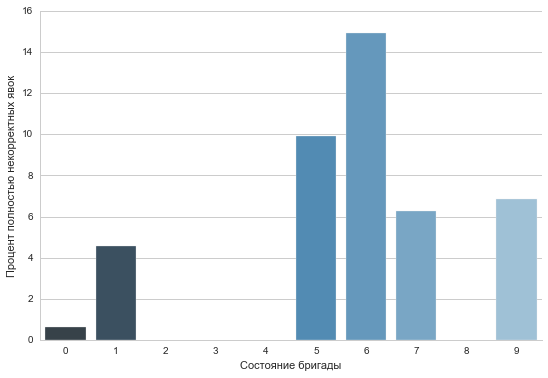

In [126]:
ready_cols = ['team', 'state', 'ready_type', 'depot_st', 'depot_time', 'return_st', 'return_time', 'rest_time', 'loco']

team_info.state.replace(')', '-1', inplace=True)
t_minus = team_info.loc[(team_info.depot_st == '-1') &
                       (team_info.depot_time == -1) & 
                       (team_info.return_st == '-1') & 
                       (team_info.return_time == -1) & 
                       (team_info.rest_time == -1)]

t_minus_loco = t_minus.loc[t_minus.loco != '-1']
#print('Всего %d бригад с полностью некорректными данными по явке (показаны первые 5), из них с локомотивами %d:' \
#      % (len(t_minus.index), len(t_minus_loco.index)))
#print(t_minus[ready_cols].head().to_string(index=False))
t_all_state = team_info.state.value_counts().to_frame()
t_minus_state = t_minus.state.value_counts().to_frame()
t_minus_state.columns = ['state2']
t_join = t_all_state.join(t_minus_state).sort_index()
t_join['state_percent'] = np.round(100 * t_join.state2 / t_join.state, 2)

plot_data = t_join.ix[1:].state_percent.reset_index()
sns.set(style='whitegrid', context='notebook')
ax = sns.barplot(x='index', y='state_percent', data=plot_data, palette='Blues_d')
ax.set_xlabel('Состояние бригады')
ax.set_ylabel('Процент полностью некорректных явок')
sns.despine()